# Исследование объявлений о продаже квартир в Ленинградской области

**Цель исследования**

Определить рыночную стоимость объектов недвижимости в Ленинградской области в зависимости от различных характеристик.

**Ход исследования**

Входные данные сервиса Яндекс Недвижимость (архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет) - находятся в файле `real_estate_data.csv`. О качестве данных ничего не известно. Поэтому перед проверкой гипотез понадобится обзор данных. 

Необходимо проверить данные на ошибки и оценить их влияние на исследование. Затем, на этапе предобработки найти возможность исправить самые критичные ошибки данных. Известно, что по каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных.
 
План проекта:
 1. [Описание данных](#1)
 
 
 2. [Предобработка данных](#2)
 
 
 3. [Исследовательский анализ данных](#3)
 
      3.1 [Исследование основных параметров объектов](#4)
      
      3.2 [Зависимость цены от различных факторов](#5)
      
      3.3 [Выделение 10 локаций с наибольшим количеством объявлений](#6)
      
      3.4 [Выделение центра Санкт-Петербурга](#7)
      
      
 4. [Вывод](#8)

## Описание данных: <a id='1'></a>

airports_nearest — расстояние до ближайшего аэропорта в метрах (м)

balcony — число балконов

ceiling_height — высота потолков (м)

cityCenters_nearest — расстояние до центра города (м)

days_exposition — сколько дней было размещено объявление (от публикации до снятия)

first_day_exposition — дата публикации

floor — этаж

floors_total — всего этажей в доме

is_apartment — апартаменты (булев тип)

kitchen_area — площадь кухни в квадратных метрах (м²)

last_price — цена на момент снятия с публикации

living_area — жилая площадь в квадратных метрах (м²)

locality_name — название населённого пункта

open_plan — свободная планировка (булев тип)

parks_around3000 — число парков в радиусе 3 км

parks_nearest — расстояние до ближайшего парка (м)

ponds_around3000 — число водоёмов в радиусе 3 км

ponds_nearest — расстояние до ближайшего водоёма (м)

rooms — число комнат

studio — квартира-студия (булев тип)

total_area — площадь квартиры в квадратных метрах (м²)

total_images — число фотографий квартиры в объявлении


In [1]:
# Подгружаем необходимые библиотеки

import pandas as pd
import os 
import matplotlib.pyplot as plt 
import matplotlib.style
pd.set_option('float_format', '{:f}'.format)
import seaborn as sns
import numpy as np
from fuzzywuzzy import fuzz
from datetime import timedelta
import warnings
warnings.simplefilter("ignore", ResourceWarning)
warnings.simplefilter("ignore", FutureWarning)


In [2]:
# Задаем стиль для графиков

sns.set (
    font_scale=1.3,
    style='whitegrid'
)

In [3]:
# Создаем датафрейм

if os.path.exists(r'C:\Users\abagapov\Downloads\real_estate_data.csv'):
    df = pd.read_csv(r'C:\Users\abagapov\Downloads\real_estate_data.csv', sep='\t')
else:
    df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
    
df.name = 'appartmens_dataset'

In [4]:
def first_view(df):
    '''
    Фунция, дающая общее представление о датасете
    '''
    print('Таблица:', df.name)
    print('*'*50)
    print('Общая информация о датасете:')
    print('*'*50)
    df.info('*'*50) 
    print('*'*50)
    print('Пять случайных строк таблицы:')
    display(df.sample(5, random_state=42)) 
    print('*'*50)
    print('Статистические параметры таблицы:')
    display(df.describe())
    print('*'*50)
    print('Количество пустых значений:')
    display(pd.DataFrame(df.isna().sum()).style.background_gradient('coolwarm')) 
    print('*'*50)
    print('Доля пропусков в столбцах:')
    display(pd.DataFrame(df.isna().mean()).style.background_gradient('coolwarm'))
    print('*'*50)
    print('Количество дубликатов:')
    print(df.duplicated().sum()) 
    print('*'*50)

## Предобработка данных <a id='2'></a>

In [5]:
# Посмотрим информацию по датасету

first_view(df)

Таблица: appartmens_dataset
**************************************************
Общая информация о датасете:
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
7944,14,2990000.000000,35.000000,2019-03-29T00:00:00,1,NaN,17.000000,16.000000,10,NaN,...,9.000000,NaN,Мурино,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7539,8,3790000.000000,33.000000,2018-12-18T00:00:00,1,2.500000,7.000000,18.000000,2,NaN,...,5.600000,NaN,Санкт-Петербург,27455.000000,8621.000000,1.000000,217.000000,0.000000,NaN,90.000000
9889,1,12990000.000000,191.000000,2017-08-31T00:00:00,7,3.300000,5.000000,136.100000,2,NaN,...,16.000000,0.000000,Санкт-Петербург,26856.000000,5704.000000,0.000000,NaN,1.000000,1017.000000,77.000000
649,1,7210000.000000,61.500000,2018-10-02T00:00:00,3,2.920000,5.000000,43.200000,4,NaN,...,5.700000,1.000000,Санкт-Петербург,25407.000000,3982.000000,1.000000,483.000000,0.000000,NaN,89.000000
13768,10,550000.000000,36.000000,2017-08-22T00:00:00,1,NaN,2.000000,20.000000,1,NaN,...,8.000000,0.000000,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,92.000000


**************************************************
Статистические параметры таблицы:


,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,23699.000000,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6541548.771552,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,10887013.267545,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,12190.000000,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3400000.000000,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4650000.000000,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6800000.000000,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,763000000.000000,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


**************************************************
Количество пустых значений:


,0
total_images,0
last_price,0
total_area,0
first_day_exposition,0
rooms,0
ceiling_height,9195
floors_total,86
living_area,1903
floor,0
is_apartment,20924


**************************************************
Доля пропусков в столбцах:


,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,0.387991
floors_total,0.003629
living_area,0.080299
floor,0.000000
is_apartment,0.882906


**************************************************
Количество дубликатов:
0
**************************************************


In [6]:
# Изменим тип first_day_exposition на дату

df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M')

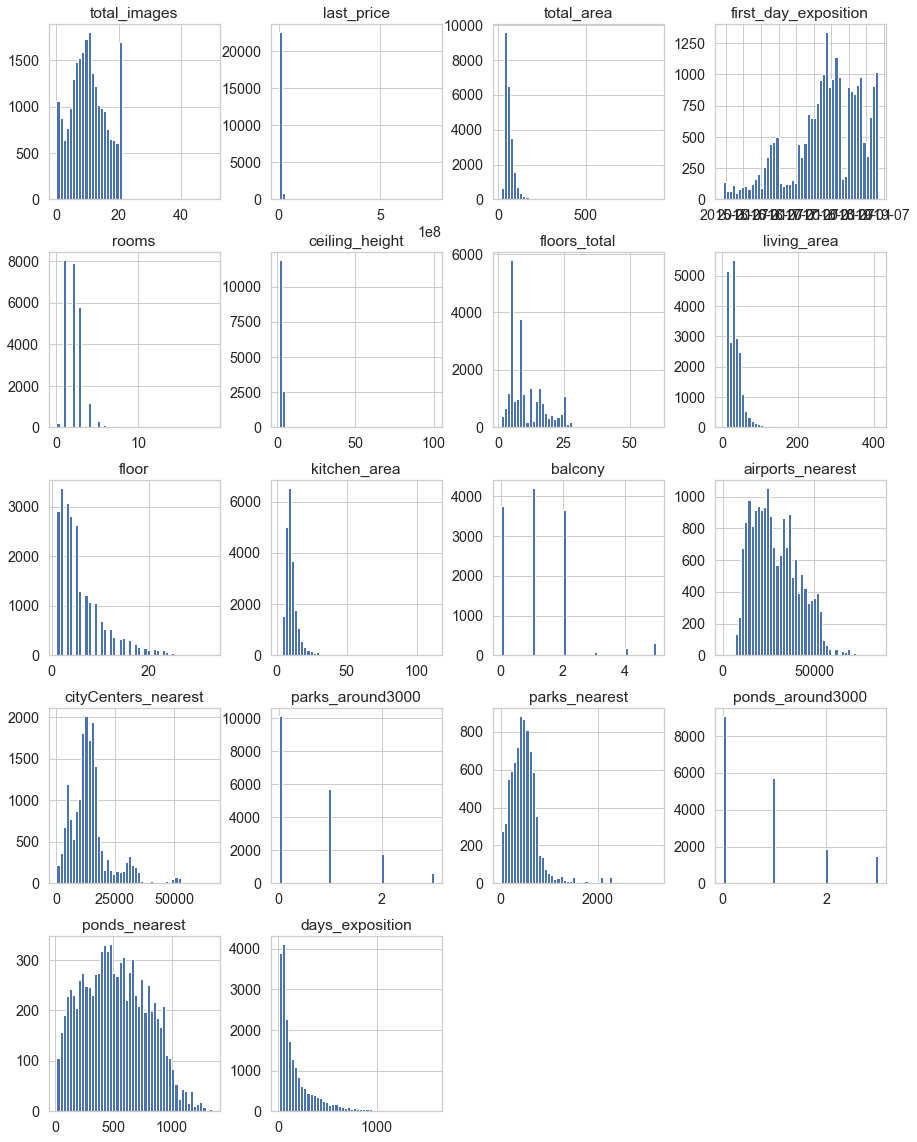

In [7]:
# Построим гистограмму

df.hist(figsize=(15, 20), bins=50);

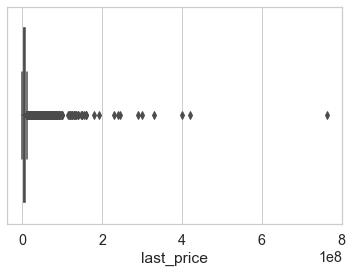

last_price


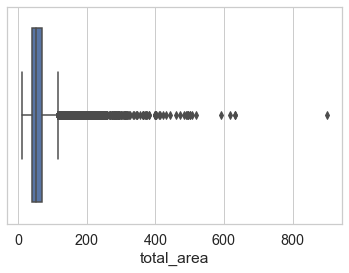

total_area


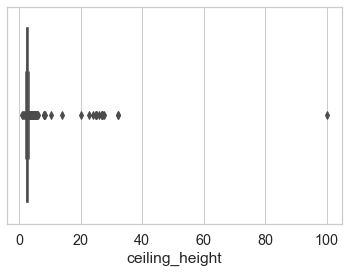

ceiling_height


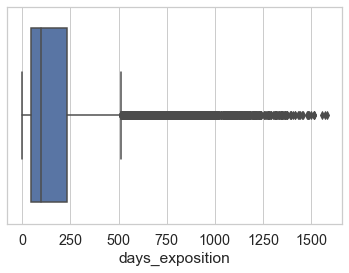

days_exposition


In [8]:
# Построим некоторые боксплоты

for column in df[['last_price', 'total_area', 'ceiling_height', 'days_exposition']]:
    try:
        sns.boxplot(df[column])
        plt.show()
        print(column)
    except:
        pass


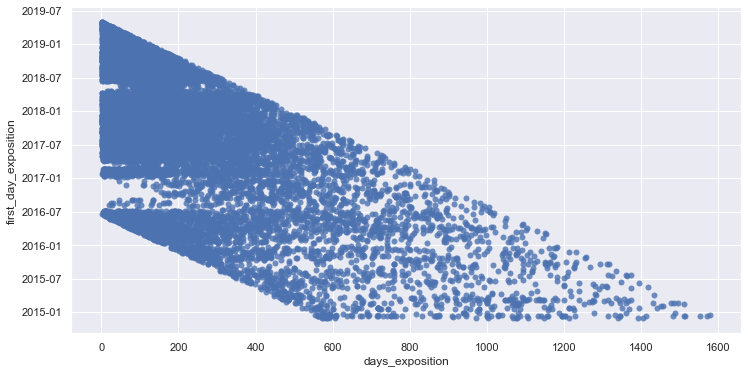

In [9]:
# Посмотрим, зависимы ли между собой first_day_exposition и days_exposition

sns.set (rc={'figure.figsize':(12,6)})
sns.scatterplot(data=df, x='days_exposition', y='first_day_exposition', linewidth=0, alpha=0.8);

Определенно, есть зависимость между переменными. Существует пустое пространство в 2005 для объектом, продающихся меняя 600 дней. Возможно, это объекты просто не попали в выборку. 

Существуют следующие проблемы:

1. Пропуски в столбцах ceiling_height, floors_total, living_area, is_apartment, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition.
2. Существуют на первый взгляд неправдоподобно дорогие и дешевые объекты.
3. Странный пик на гистограмме фотографий на 20 штуках при практически полном отсутствии фотографией после.
4. Слишком большая этажность некоторых зданий (самое высокоэтажное здание в Лен. области - 42 этажа).
5. Неправдоподобная высота потолков (менее 2.5м и более 11м).
6. Существуют объекты с нулевым количеством комнат. Возможно, таким образом обозначаются студии.
7. Подозрительно низкие минимальные значения жилой площади и кухни.
8. Неявные дубликаты в названиях населенных пунктов.

Посмотрим внимательнее на столбцы с пропусками:

    ceiling_height - пропуски можно объяснить ошибкой пользователя при вводе данных. Столбец не участвует в расчетах, но значения можно поменять на медианные для эстетики.
    
    floors_total - пропуски можно объяснить ошибкой пользователя при вводе данных. Доля пропусков очень мала, но стобец нужен для определения категории квартиры относительно этажа (первый, последний, другой), поэтому строки с пропусками лучше удалить - восстановить этажность вряд ли возможно.
    
    living_area - пропуски можно объяснить ошибкой пользователя при вводе данных. Так как столбец участвует в расчетах, пустые значения будут заменены медианным относительно числа комнат.
    
    is_apartment - пропуски можно объяснить ошибкой пользователя при вводе данных. Пропуски в данных - большая часть столбца. Исходя из того, что значений True во много раз меньше, чем False, можно предположить, что пустые значения (по крайней мере, большая их часть) также должны иметь значение False. 
    
    kitchen_area - пропуски можно объяснить ошибкой пользователя при вводе данных. Так как столбец участвует в расчетах, пустые значения будут заменены медианными относительно числа комнат.
    
    balcony - пропуски можно объяснить ошибкой пользователя при вводе данных. Пустые значения можно заменить на 0, предполагая, что балконов нет.
    
    locality_name - пропуски можно объяснить ошибкой пользователя при вводе данных. Доля пропусков очень мала, но локация важна для анализа, поэтому строки с пустыми значениями придется удалить т.к. locality_name восстановить по данным нельзя.
    
    airports_nearest - значения должны были быть получены автоматически из картографических данных, следовательно, пропуски существуют из-за технической проблемы. Столбец в анализе не участвует, поэтому пропуски можно оставить.
    
    cityCenters_nearest - значения должны были быть получены автоматически из картографических данных, следовательно, пропуски существуют из-за технической проблемы. Столбец участвует в анализе, поэтому пропуски хотелось бы заменить средними по локациям, но существуют локации, в которых все значения пустые (например, Выборг). Следовательно, пропуски на таких локациях не получится заполнить и их приедется оставить.
    
    parks_around3000 - значения должны были быть получены автоматически из картографических данных, следовательно, пропуски существуют из-за технической проблемы. Столбец в анализе не участвует, поэтому пропуски можно оставить.
    
    parks_nearest - значения должны были быть получены автоматически из картографических данных, следовательно, пропуски существуют из-за технической проблемы. Столбец в анализе не участвует, поэтому пропуски можно оставить.
    
    ponds_around3000 - значения должны были быть получены автоматически из картографических данных, следовательно, пропуски существуют из-за технической проблемы. Столбец в анализе не участвует, поэтому пропуски можно оставить.
    
    ponds_nearest - значения должны были быть получены автоматически из картографических данных, следовательно, пропуски существуют из-за технической проблемы. Столбец в анализе не участвует, поэтому пропуски можно оставить.
    
    days_exposition - значения должны были быть получены автоматически, следовательно, пропуски существуют из-за технической проблемы. Столбец участвует в анализе, но значения заменить не получится так как пропуски не являются абсолютно случайными.


In [10]:
# Заполним прописки в ceiling_height медианными значениями

df['ceiling_height'].fillna(df['ceiling_height'].median(), inplace=True)

In [11]:
# Проверим

df['ceiling_height'].isna().sum()

0

In [12]:
sorted(df['ceiling_height'].unique())

[1.0,
 1.2,
 1.75,
 2.0,
 2.2,
 2.25,
 2.3,
 2.34,
 2.4,
 2.45,
 2.46,
 2.47,
 2.48,
 2.49,
 2.5,
 2.51,
 2.52,
 2.53,
 2.54,
 2.55,
 2.56,
 2.57,
 2.58,
 2.59,
 2.6,
 2.61,
 2.62,
 2.63,
 2.64,
 2.65,
 2.66,
 2.67,
 2.68,
 2.69,
 2.7,
 2.71,
 2.72,
 2.73,
 2.74,
 2.75,
 2.76,
 2.77,
 2.78,
 2.79,
 2.8,
 2.81,
 2.82,
 2.83,
 2.84,
 2.85,
 2.86,
 2.87,
 2.88,
 2.89,
 2.9,
 2.91,
 2.92,
 2.93,
 2.94,
 2.95,
 2.96,
 2.97,
 2.98,
 2.99,
 3.0,
 3.01,
 3.02,
 3.03,
 3.04,
 3.05,
 3.06,
 3.07,
 3.08,
 3.09,
 3.1,
 3.11,
 3.12,
 3.13,
 3.14,
 3.15,
 3.16,
 3.17,
 3.18,
 3.2,
 3.21,
 3.22,
 3.23,
 3.24,
 3.25,
 3.26,
 3.27,
 3.28,
 3.29,
 3.3,
 3.31,
 3.32,
 3.33,
 3.34,
 3.35,
 3.36,
 3.37,
 3.38,
 3.39,
 3.4,
 3.42,
 3.43,
 3.44,
 3.45,
 3.46,
 3.47,
 3.48,
 3.49,
 3.5,
 3.51,
 3.52,
 3.53,
 3.54,
 3.55,
 3.56,
 3.57,
 3.58,
 3.59,
 3.6,
 3.62,
 3.63,
 3.65,
 3.66,
 3.67,
 3.68,
 3.69,
 3.7,
 3.75,
 3.76,
 3.78,
 3.8,
 3.82,
 3.83,
 3.84,
 3.85,
 3.86,
 3.87,
 3.88,
 3.9,
 3.93,
 3.95,
 3.98,

Учитывая стандартную высоту потолков в 2.5м, предположим, что потолки менее 2.4 и более 10.3 м - неадекватны. Предположим, что высота потолков от 24м до 100м - ошибка при вводе и поделим данные значения на 10. Остальные потолки с малореальными значениями заменим на медианный.

In [13]:
# Посмотрим на объекты с неправдоподобным количесивом этажей

df.query('floors_total > 42')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2253,12,3800000.000000,45.500000,2018-06-28,2,2.880000,60.000000,27.400000,4,NaN,...,7.400000,NaN,Кронштадт,67763.000000,49488.000000,2.000000,342.000000,3.000000,614.000000,166.000000
16731,9,3978000.000000,40.000000,2018-09-24,1,2.650000,52.000000,10.500000,18,NaN,...,14.000000,NaN,Санкт-Петербург,20728.000000,12978.000000,1.000000,793.000000,0.000000,NaN,45.000000


Так как таких объектов немного - удалим

In [14]:
# Посмотим на самые дорогие квартиры

df.sort_values('last_price', ascending=False).head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
12971,19,763000000.000000,400.000000,2017-09-30,7,2.650000,10.000000,250.000000,10,NaN,...,NaN,2.000000,Санкт-Петербург,25108.000000,3956.000000,1.000000,530.000000,3.000000,756.000000,33.000000
19540,8,420000000.000000,900.000000,2017-12-06,12,2.800000,25.000000,409.700000,25,NaN,...,112.000000,NaN,Санкт-Петербург,30706.000000,7877.000000,0.000000,NaN,2.000000,318.000000,106.000000
14706,15,401300000.000000,401.000000,2016-02-20,5,2.650000,9.000000,204.000000,9,False,...,24.000000,3.000000,Санкт-Петербург,21912.000000,2389.000000,1.000000,545.000000,1.000000,478.000000,393.000000
1436,19,330000000.000000,190.000000,2018-04-04,3,3.500000,7.000000,95.000000,5,NaN,...,40.000000,NaN,Санкт-Петербург,23011.000000,1197.000000,3.000000,519.000000,3.000000,285.000000,233.000000
15651,20,300000000.000000,618.000000,2017-12-18,7,3.400000,7.000000,258.000000,5,NaN,...,70.000000,NaN,Санкт-Петербург,32440.000000,5297.000000,0.000000,NaN,2.000000,198.000000,111.000000
22831,18,289238400.000000,187.500000,2019-03-19,2,3.370000,6.000000,63.700000,6,NaN,...,30.200000,NaN,Санкт-Петербург,22494.000000,1073.000000,3.000000,386.000000,3.000000,188.000000,NaN
16461,17,245000000.000000,285.700000,2017-04-10,6,3.350000,7.000000,182.800000,4,NaN,...,29.800000,NaN,Санкт-Петербург,33143.000000,6235.000000,3.000000,400.000000,3.000000,140.000000,249.000000
13749,7,240000000.000000,410.000000,2017-04-01,6,3.400000,7.000000,218.000000,7,NaN,...,40.000000,0.000000,Санкт-Петербург,32440.000000,5297.000000,0.000000,NaN,2.000000,198.000000,199.000000
5893,3,230000000.000000,500.000000,2017-05-31,6,2.650000,7.000000,NaN,7,NaN,...,40.000000,0.000000,Санкт-Петербург,32440.000000,5297.000000,0.000000,NaN,2.000000,198.000000,50.000000
8900,13,190870000.000000,268.000000,2016-03-25,3,2.650000,8.000000,132.000000,7,NaN,...,40.000000,NaN,Санкт-Петербург,32440.000000,5297.000000,0.000000,NaN,2.000000,198.000000,901.000000


Самая дорогая квартира кажется нереалистичной, но, видимо, она действительно существует - https://www.spb.kp.ru/daily/21712099.5/4336963/

Все же удалим ее самую дорогую недвижимость, чтобы она не искажала результаты.

In [15]:
# Посмотим на самые дешевые квартиры

df.sort_values('last_price').head(4)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12190.000000,109.000000,2019-03-20,2,2.750000,25.000000,32.000000,25,NaN,...,40.500000,NaN,Санкт-Петербург,36421.000000,9176.000000,1.000000,805.000000,0.000000,NaN,8.000000
17456,7,430000.000000,30.400000,2019-04-22,1,2.650000,2.000000,16.000000,1,NaN,...,6.000000,NaN,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14911,5,430000.000000,54.000000,2018-06-26,2,2.650000,3.000000,NaN,3,NaN,...,NaN,NaN,посёлок станции Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.000000
16274,18,440000.000000,40.000000,2018-07-10,1,2.650000,5.000000,NaN,1,NaN,...,NaN,NaN,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45.000000


Лишь первая строчка кажется выбросом, поэтому удалим ее.

In [16]:
# Посмотим на самые большые по площади квартиры

df.sort_values('total_area', ascending=False).head(4)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19540,8,420000000.000000,900.000000,2017-12-06,12,2.800000,25.000000,409.700000,25,NaN,...,112.000000,NaN,Санкт-Петербург,30706.000000,7877.000000,0.000000,NaN,2.000000,318.000000,106.000000
12859,20,140000000.000000,631.200000,2019-04-09,7,3.900000,4.000000,322.300000,4,NaN,...,19.500000,1.000000,Санкт-Петербург,25707.000000,4972.000000,0.000000,NaN,2.000000,210.000000,NaN
3117,19,140000000.000000,631.000000,2019-03-30,7,2.650000,5.000000,NaN,5,NaN,...,60.000000,NaN,Санкт-Петербург,25707.000000,4972.000000,0.000000,NaN,2.000000,210.000000,NaN
15651,20,300000000.000000,618.000000,2017-12-18,7,3.400000,7.000000,258.000000,5,NaN,...,70.000000,NaN,Санкт-Петербург,32440.000000,5297.000000,0.000000,NaN,2.000000,198.000000,111.000000


Видимо, квартиры с такой площадью действительно существуют - https://asninfo.ru/comfortlive/210-samyye-bolshiye-kvartiry-sankt-peterburga

In [17]:
# Посмотим на самые маленькие по площади квартиры

df.sort_values('total_area').head(4)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19904,4,2400000.000000,12.000000,2017-07-19,1,2.550000,5.000000,10.000000,2,NaN,...,NaN,NaN,Санкт-Петербург,21314.000000,964.000000,1.000000,886.000000,2.000000,45.000000,200.000000
17961,3,1400000.000000,13.000000,2017-12-03,1,2.600000,9.000000,NaN,1,NaN,...,NaN,NaN,Санкт-Петербург,14350.000000,15945.000000,0.000000,NaN,1.000000,185.000000,410.000000
19546,3,1850000.000000,13.000000,2019-03-11,1,3.400000,5.000000,NaN,2,False,...,NaN,NaN,Санкт-Петербург,24915.000000,5483.000000,1.000000,644.000000,0.000000,NaN,24.000000
19807,0,3800000.000000,13.000000,2018-07-04,1,2.650000,5.000000,10.000000,3,NaN,...,NaN,NaN,Санкт-Петербург,21302.000000,1242.000000,1.000000,592.000000,3.000000,27.000000,9.000000


И такие маленькие студии тоже вполне возможны. Странно, что они сами как студии не обозначены.

In [18]:
# Посмотри на квартиры без комнат, но с большой площадью.

df.query('rooms == 0 and total_area > 35')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3458,6,7400000.000000,73.600000,2017-05-18,0,2.650000,3.000000,50.000000,1,NaN,...,NaN,0.000000,Санкт-Петербург,26581.000000,6085.000000,0.000000,NaN,1.000000,348.000000,60.000000
7237,8,2999000.000000,42.630000,2017-11-27,0,2.650000,16.000000,25.700000,2,NaN,...,NaN,2.000000,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,45.000000
9052,12,3890000.000000,38.300000,2017-10-06,0,2.700000,14.000000,24.420000,7,NaN,...,NaN,2.000000,Санкт-Петербург,15493.000000,14289.000000,0.000000,NaN,0.000000,NaN,289.000000
10008,20,5050000.000000,44.200000,2017-09-14,0,2.700000,9.000000,32.200000,1,NaN,...,NaN,NaN,Санкт-Петербург,24329.000000,5955.000000,0.000000,NaN,2.000000,520.000000,69.000000
13613,16,8100000.000000,58.400000,2019-04-26,0,3.300000,7.000000,33.000000,6,NaN,...,NaN,NaN,Санкт-Петербург,14509.000000,8288.000000,0.000000,NaN,0.000000,NaN,NaN
15319,4,5970000.000000,43.300000,2017-07-20,0,2.800000,9.000000,28.200000,2,NaN,...,NaN,2.000000,Санкт-Петербург,23617.000000,5223.000000,0.000000,NaN,1.000000,874.000000,30.000000
16130,14,5000000.000000,42.100000,2018-04-13,0,2.650000,20.000000,30.000000,10,NaN,...,NaN,NaN,Санкт-Петербург,50605.000000,15933.000000,0.000000,NaN,0.000000,NaN,170.000000
19392,5,71000000.000000,371.000000,2018-07-26,0,3.570000,7.000000,NaN,6,NaN,...,NaN,NaN,Санкт-Петербург,25257.000000,6060.000000,1.000000,761.000000,1.000000,584.000000,90.000000
20082,10,16300000.000000,98.400000,2017-11-08,0,3.100000,5.000000,60.500000,2,NaN,...,NaN,NaN,Санкт-Петербург,26972.000000,5819.000000,0.000000,NaN,1.000000,674.000000,537.000000
21227,0,8200000.000000,71.000000,2017-07-21,0,5.800000,5.000000,68.000000,5,NaN,...,NaN,0.000000,Санкт-Петербург,20170.000000,1261.000000,2.000000,295.000000,3.000000,366.000000,30.000000


Вероятно, нулевое количество комнат можно объяснить ошибкой пользователя при вводе. Так как нужно будет проверять корреляцию комнат и цены, а данные объектов мало, удалим их.

In [19]:
# Проверим, превышает ли общая площадь суммарную жилой и кухни

df.query('total_area < (living_area + kitchen_area)')['total_area'].count()

64

Данные объекты придется удалить

In [20]:
# Посмотрим, есть ли объекты с маленькой жилой площадью и несколькими комнатами

df.query('living_area < 10 and rooms >= 2')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1326,8,8100000.000000,52.000000,2017-01-29,2,2.700000,25.000000,9.000000,15,NaN,...,32.000000,2.000000,Санкт-Петербург,35555.000000,15561.000000,0.000000,NaN,1.000000,1180.000000,337.000000
2309,10,4200000.000000,62.400000,2017-06-15,2,2.600000,9.000000,8.400000,6,NaN,...,41.000000,2.000000,посёлок Шушары,23662.000000,29448.000000,0.000000,NaN,0.000000,NaN,111.000000
7312,8,3400000.000000,27.000000,2018-02-21,2,2.500000,15.000000,9.000000,4,NaN,...,16.000000,NaN,Санкт-Петербург,50246.000000,16444.000000,1.000000,617.000000,0.000000,NaN,NaN
8325,9,4800000.000000,52.000000,2017-10-25,2,2.650000,5.000000,9.000000,2,NaN,...,6.000000,1.000000,Санкт-Петербург,33358.000000,13171.000000,0.000000,NaN,2.000000,118.000000,119.000000
13915,20,6350000.000000,52.000000,2018-02-06,2,3.000000,6.000000,2.000000,2,NaN,...,9.000000,NaN,Санкт-Петербург,32453.000000,6521.000000,0.000000,NaN,1.000000,1012.000000,91.000000
20994,7,8900000.000000,50.600000,2018-10-22,2,2.500000,7.000000,8.000000,3,NaN,...,31.000000,NaN,Санкт-Петербург,12771.000000,8301.000000,1.000000,173.000000,3.000000,126.000000,NaN
21943,15,6100000.000000,77.600000,2019-02-28,4,2.500000,9.000000,5.400000,1,NaN,...,9.800000,NaN,Санкт-Петербург,29338.000000,11270.000000,1.000000,584.000000,0.000000,NaN,33.000000
22473,0,3490304.000000,33.260000,2015-12-22,2,2.650000,13.000000,9.100000,9,NaN,...,16.400000,0.000000,Санкт-Петербург,33626.000000,13495.000000,0.000000,NaN,0.000000,NaN,199.000000
23574,14,64990000.000000,139.000000,2015-11-24,3,3.000000,8.000000,3.000000,8,NaN,...,16.000000,1.000000,Санкт-Петербург,33255.000000,5975.000000,1.000000,630.000000,3.000000,100.000000,280.000000


Такая ситуация кажется неправдоподобной, поэтому удалим объекты.

In [21]:
# Замена пропусков

df['is_apartment'].fillna(False) # пропуски в is_apartment можно заменить на False
df['balcony'].fillna(0) # пропуски в balcony можно заменить на 0

0       0.000000
1       2.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
23694   0.000000
23695   0.000000
23696   0.000000
23697   2.000000
23698   0.000000
Name: balcony, Length: 23699, dtype: float64

In [22]:
# Приведем потолки к медианному размеру

for i, row in df.iterrows():
    if row['ceiling_height'] < 2.4 or (row['ceiling_height'] > 10.5 and row['ceiling_height'] < 24):
        df['ceiling_height'].replace(row['ceiling_height'], df['ceiling_height'].median(), inplace=True)
    elif row['ceiling_height'] >= 24:
        df['ceiling_height'].replace(row['ceiling_height'], row['ceiling_height'] / 10, inplace=True)

In [23]:
# Удаление строк

df.drop(index=8793, inplace=True) # самый дешевый объект
df.query('floors_total <= 42', inplace=True) # с мнимыми высотками
df.query('~ (rooms == 0 and total_area > 35)', inplace=True) # псевдо-студии
df.query('total_area >= (living_area + kitchen_area) or living_area != living_area or kitchen_area != kitchen_area', 
         inplace=True) # объекты, где общая площадь меньше 
                                                                  # суммарной жилой и кухни
df.query('~ (living_area < 10 and rooms >= 2)', inplace=True) # объекты с маленькой жилой площадью 
                                                              # и несколькими комнатами
df.query('total_area < 250', inplace=True) # с большой площадью
#df.reset_index(inplace=True)

In [24]:
# Изменение типов данных

df['balcony'] = df['balcony'].astype('bool') # balcony к булевому формату
df['floors_total'] = df['floors_total'].astype('int64') # floors_total к числовому

In [25]:
df['locality_name'].nunique()

364

In [26]:
# Начнем борьбу с дубликатами

df['locality_name'] = df['locality_name'].str.replace('ё', 'е')
df['locality_name'] = df['locality_name'].str.replace('городской поселок', 'поселок')
df['locality_name'] = df['locality_name'].str.replace('поселок городского типа', 'поселок')
df['locality_name'] = df['locality_name'].str.replace('коттеджный поселок', 'поселок')

In [27]:
#Проверим оставшиеся дубликаты, используя расстояние Леванштейна

for a in df[df['locality_name'] == df['locality_name']]['locality_name'].unique():
    for b in df[df['locality_name'] == df['locality_name']]['locality_name'].unique():
        s = fuzz.partial_ratio(a, b)
        if s > 95 and a != b:
            print(a, b)

поселок Мурино Мурино
деревня Кудрово Кудрово
Коммунар поселок Коммунары
Кингисепп поселок Кингисеппский
деревня Старая деревня Старая Пустошь
Мурино поселок Мурино
Никольское село Никольское
Кудрово деревня Кудрово
Луга поселок Усть-Луга
поселок Усть-Луга Луга
село Никольское Никольское
село Русско-Высоцкое Высоцк
Любань поселок Любань
поселок Кингисеппский Кингисепп
деревня Старая Пустошь деревня Старая
поселок Коммунары Коммунар
деревня Бор деревня Борисова Грива
поселок Любань Любань
Высоцк село Русско-Высоцкое
деревня Борисова Грива деревня Бор


In [28]:
# Удалим оставшиеся дубликаты

list_old = ['деревня Кудрово', 'поселок Мурино', 'село Никольское', 'поселок Любань']
list_new = ['Кудрово', 'Мурино', 'Никольское', 'Любань']

df['locality_name'] = df['locality_name'].replace(list_old, list_new)

In [29]:
df['locality_name'].nunique()

317

In [30]:
# Заполним отсутствующие значения столбца

df['locality_name'].fillna('Другой населенный пункт', inplace=True)

In [31]:
# Проверим

df['locality_name'].nunique()

318

Неявные дубликаты побеждены

In [32]:
# Добавим столбец с ценой квадратного метра
df['meter_price'] = df['last_price'] / df['total_area']

In [33]:
# Заполним отсутствующие значения расстояния до центра по медианными по локациям

df['cityCenters_nearest'] = (
    df['cityCenters_nearest'].
    fillna(df.groupby('locality_name')['cityCenters_nearest'].transform("median"))
    )

In [34]:
# Напишем функцию, возвращающую категорию этажа квартиры

def floor_category(floor, floors_total, axis=0):
    '''
    Фунция, определяющая категорию этажа
    '''
    if floor == floors_total:
        return 'последний'
    elif floor == 1:
        return 'первый'
    else: 
        return 'другой'
 

In [35]:
# Добавление новых столбцов

df['floor_category'] = df.apply(lambda x: floor_category(x['floor'], x['floors_total']), axis=1) # категория этажа 

df['living_total_area_ratio'] = df['living_area'] / df['total_area'] # соотношение жилой и общей площади

df['weekday_first'] = df['first_day_exposition'].dt.weekday # день недели публикации объявления

df['month_first'] = df['first_day_exposition'].dt.month # месяц публицации объявления

df['year_first'] = df['first_day_exposition'].dt.year # год публикации объявления

df['last_day_exposition'] = (
    df['first_day_exposition'] + df['days_exposition']
    .apply(lambda x: timedelta(days=x) if x == x else timedelta(days=0)) # последний день публикации объявления
                            )

df['last_day_exposition'] = (
    df['last_day_exposition']
    .where(cond=(df['last_day_exposition'] != df['first_day_exposition']), other=np.nan)
                            )  # последний день публикации объявления

df['weekday_last'] = df['last_day_exposition'].dt.weekday # день недели снятия объявления

df['month_last'] = df['last_day_exposition'].dt.month # месяц снятия объявления

df['year_last'] = df['last_day_exposition'].dt.year # год снятия объявления

df['cityCenters_nearest_km'] = (df['cityCenters_nearest'] / 1000).round() # расстояние до центра в километрах

df['meter_price'] =  (df['last_price'] / df['total_area']).round() # цена одного квадратного метра

In [36]:
# Посмотрим коэффициент отношения жилой площади к общей по количеству комнат

area_ratio = df.groupby(['rooms'])['living_total_area_ratio'].mean()

area_ratio

rooms
0    0.685578
1    0.484625
2    0.579145
3    0.625382
4    0.647467
5    0.652459
6    0.689450
7    0.676655
8    0.716355
9    0.628251
10   0.746876
11   0.710093
14   0.685819
Name: living_total_area_ratio, dtype: float64

In [37]:
# Заполним отсутствующие значения жилой площади по коэффициентам

df['living_area'] = (
    df['living_area'].fillna(df.groupby('rooms')
                                             ['living_total_area_ratio'].transform("median") * df['total_area'])
    )

In [38]:
# Посмотрим цены объектов по перцентилям

np.percentile(df['last_price'], [90, 95, 99])

array([10690000., 14799000., 30000000.])

In [39]:
# Определим границу, после которой буем считать, что жилье является сверхдорогим и не участвует в анализе

price_celling = np.percentile(df['last_price'], 99)

df.query('last_price < @price_celling', inplace=True) # самые дорогие объекты 

In [40]:
df.sample(5, random_state=42)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,floor_category,living_total_area_ratio,weekday_first,month_first,year_first,last_day_exposition,weekday_last,month_last,year_last,cityCenters_nearest_km
9019,13,3700000.000000,48.000000,2018-10-06,2,2.500000,9,29.000000,4,False,...,другой,0.604167,5,10,2018,2019-03-28,3.000000,3.000000,2019.000000,NaN
254,10,3350000.000000,31.200000,2017-06-30,1,2.500000,9,15.600000,9,NaN,...,последний,0.500000,4,6,2017,2017-07-21,4.000000,7.000000,2017.000000,16.000000
20204,5,5800000.000000,96.300000,2016-10-29,5,2.500000,5,65.300000,3,NaN,...,другой,0.678089,5,10,2016,2018-03-30,4.000000,3.000000,2018.000000,21.000000
8874,12,6050000.000000,72.600000,2018-02-01,3,2.550000,9,49.200000,2,NaN,...,другой,0.677686,3,2,2018,2018-03-20,1.000000,3.000000,2018.000000,16.000000
22885,11,3990000.000000,38.600000,2019-03-13,1,2.500000,8,17.500000,4,NaN,...,другой,0.453368,2,3,2019,2019-04-16,1.000000,4.000000,2019.000000,16.000000


In [41]:
# Проверим

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23172 entries, 0 to 23698
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             23172 non-null  int64         
 1   last_price               23172 non-null  float64       
 2   total_area               23172 non-null  float64       
 3   first_day_exposition     23172 non-null  datetime64[ns]
 4   rooms                    23172 non-null  int64         
 5   ceiling_height           23172 non-null  float64       
 6   floors_total             23172 non-null  int64         
 7   living_area              23172 non-null  float64       
 8   floor                    23172 non-null  int64         
 9   is_apartment             2720 non-null   object        
 10  studio                   23172 non-null  bool          
 11  open_plan                23172 non-null  bool          
 12  kitchen_area             20986 n

## Исследовательский анализ данных <a id='3'></a>

### Исследование основных параметров объектов <a id='4'></a>

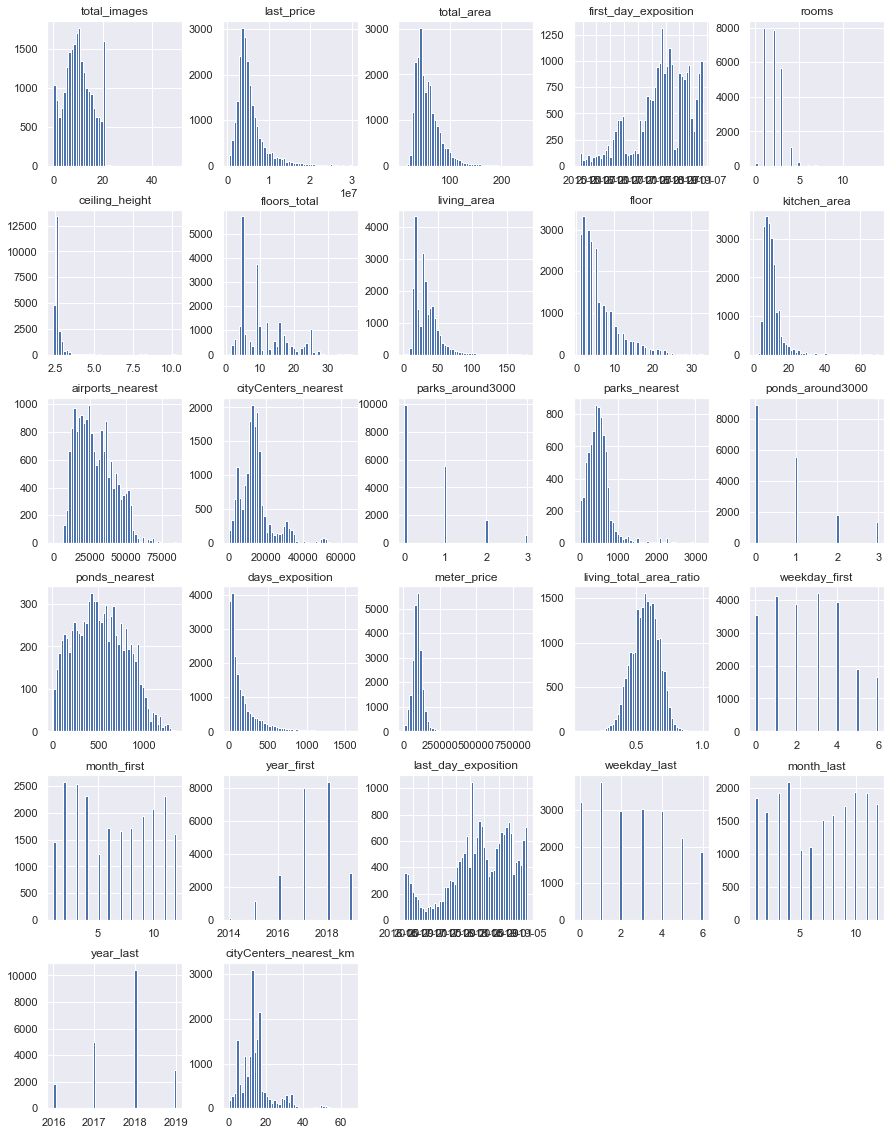

In [42]:
# Еще раз посмтроим гистрограмму для всех переменных после предобработки

df.hist(figsize=(15, 20), bins=50);

In [43]:
# Зададим функцию для отрисовки графиков

def median_mean_histplot(series, title, x, y):
    ax = sns.histplot(data=series, bins=50)
    ax.axvline(round(series.mean(), 0), linewidth=2, color='r', alpha=0.9, linestyle='--', label = 'Среднее = {:,.0f}'
           .format(round(series.mean(), 0)).replace(',', ' '))
    ax.axvline(round(series.median(), 0), linewidth=2, color='darkgreen', alpha=0.9, linestyle='--', 
               label = 'Медиана = {:,.0f}'
           .format(round(series.median(), 0)).replace(',', ' '))
    ax.set_title(title)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    plt.show();

### Цена объекта

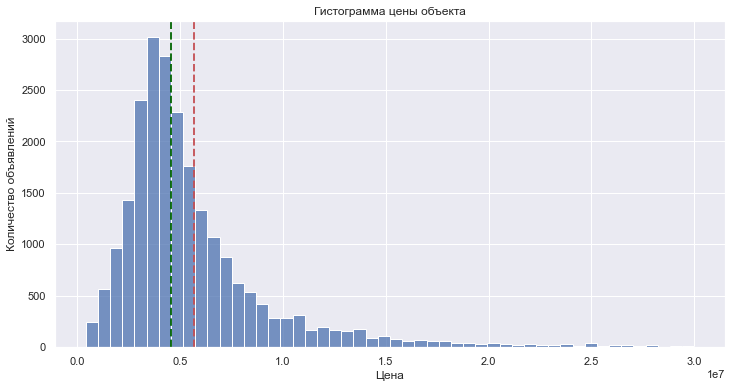

In [44]:
median_mean_histplot(df['last_price'], 'Гистограмма цены объекта', 'Цена', 'Количество объявлений')

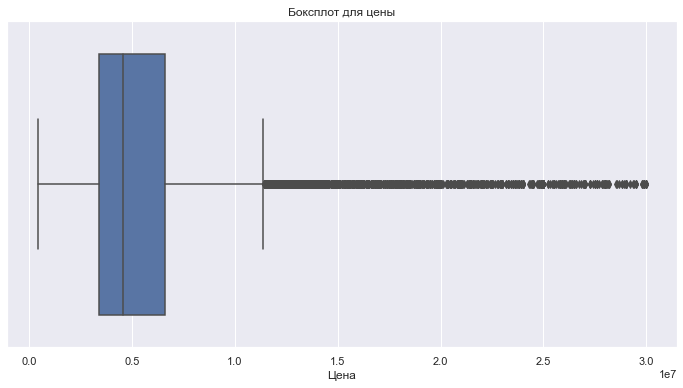

In [45]:
# Построим боксплот

ax = sns.boxplot(df['last_price'])
ax.set_title('Боксплот для цены')
ax.set_xlabel('Цена')
plt.show();

Большая часть объектов итогового датафрейма находится в ценовой категории до 12 миллионов

In [46]:
# Посмотрим на разницу между медианной и средней ценами

round(df['last_price'].mean() - df['last_price'].median())

1107258

Разница между средней и медианной ценой значительно - чувствуется влияние тяжелого хвоста.

In [47]:
# Медианная цена объекта по общему датафреймы

df['last_price'].median()

4600000.0

### Общая площадь

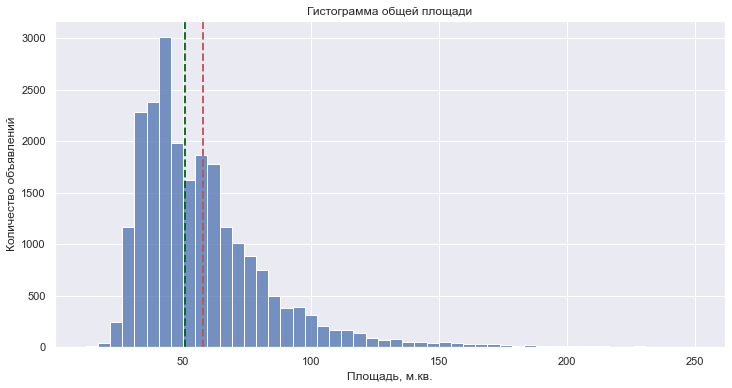

In [48]:
median_mean_histplot(df['total_area'], 'Гистограмма общей площади', 'Площадь, м.кв.', 'Количество объявлений')

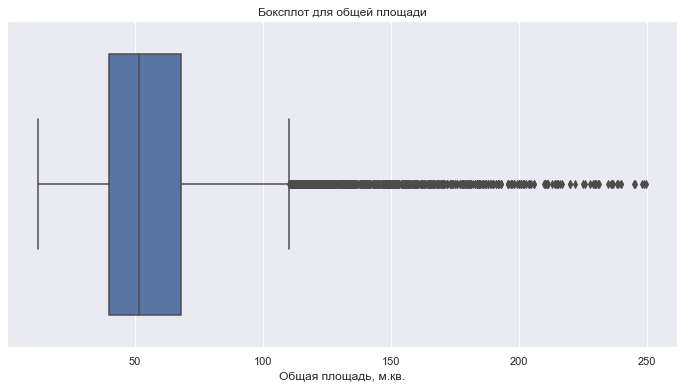

In [49]:
# Построим боксплот

ax = sns.boxplot(df['total_area'])
ax.set_title('Боксплот для общей площади')
ax.set_xlabel('Общая площадь, м.кв.')
plt.show();

Большая часть объектов итогового датафрейма имеет общую площадь до 110 кв.м.

In [50]:
# Медианная общая площадь

df['total_area'].median()

51.45

### Жилая площадь

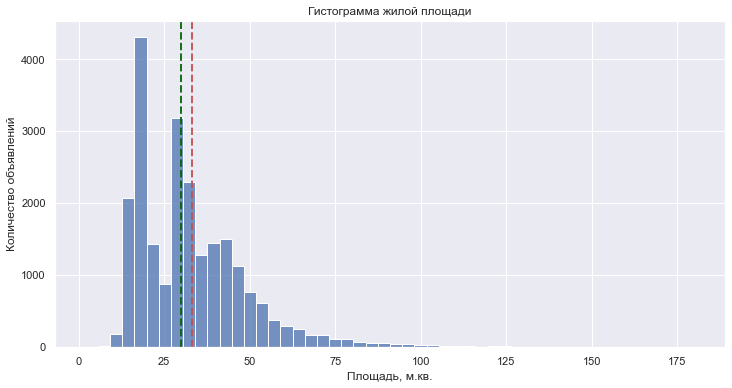

In [51]:
median_mean_histplot(df['living_area'], 'Гистограмма жилой площади', 'Площадь, м.кв.', 'Количество объявлений')

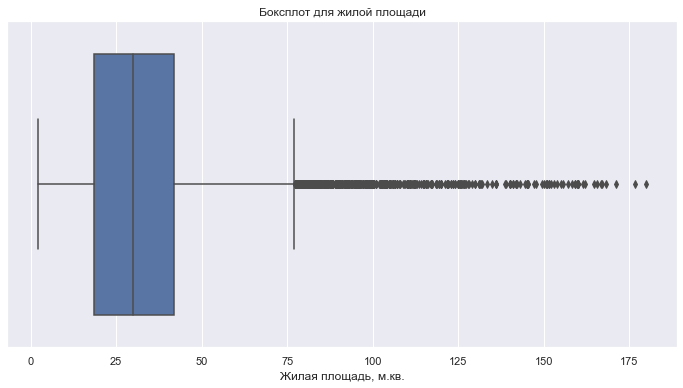

In [52]:
# Построим боксплот

ax = sns.boxplot(df['living_area'])
ax.set_title('Боксплот для жилой площади')
ax.set_xlabel('Жилая площадь, м.кв.')
plt.show();

Большая часть объектов итогового датафрейма имеет жилую площадь до 75 кв.м.

In [53]:
# Медианная жилая площадь

df['living_area'].median()

30.0

### Площадь кухни

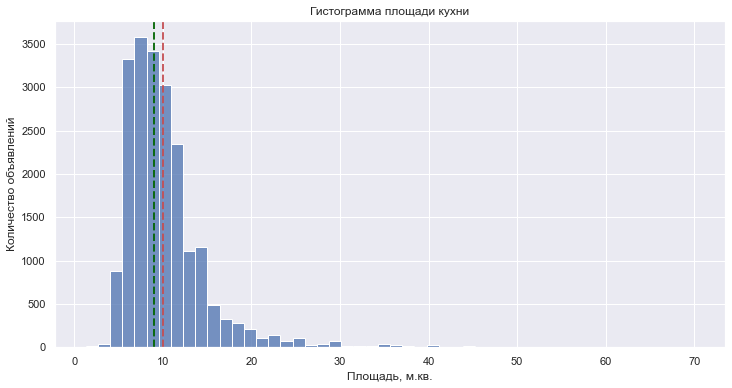

In [54]:
median_mean_histplot(df['kitchen_area'], 'Гистограмма площади кухни', 'Площадь, м.кв.', 'Количество объявлений')

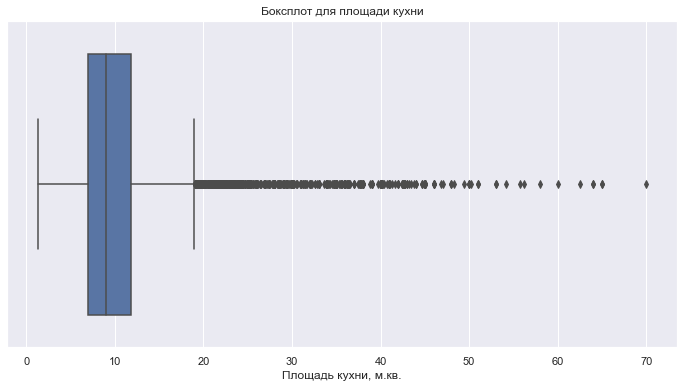

In [55]:
ax = sns.boxplot(df['kitchen_area'])
ax.set_title('Боксплот для площади кухни')
ax.set_xlabel('Площадь кухни, м.кв.')
plt.show();

Большая часть объектов итогового датафрейма имеет площадь кухни до 19 кв.м.

In [56]:
# Медианная площадь кухни

df['kitchen_area'].median()

9.0

### Время продажи

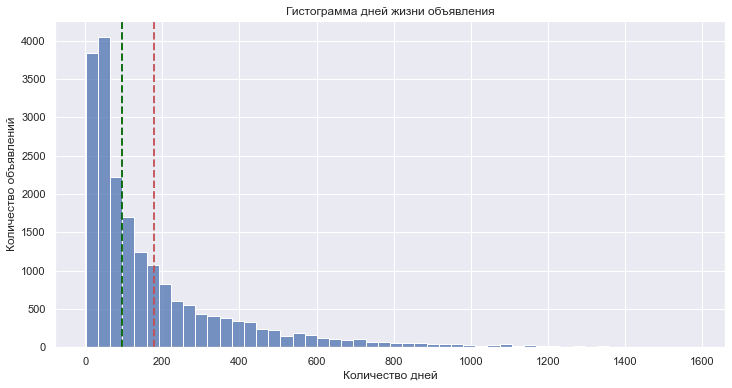

In [57]:
# Построим гистограмму по времени продажи

median_mean_histplot(df['days_exposition'], 'Гистограмма дней жизни объявления', 'Количество дней', 'Количество объявлений')

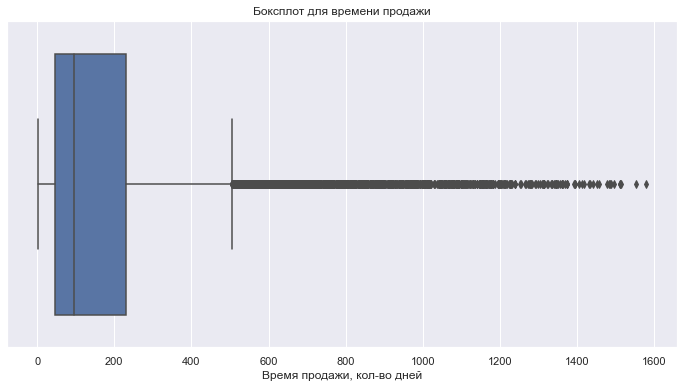

In [58]:
ax = sns.boxplot(df['days_exposition'])
ax.set_title('Боксплот для времени продажи')
ax.set_xlabel('Время продажи, кол-во дней')
plt.show();

Большая часть объектов продается менее 500 дней

In [59]:
# Найдем медианное время продажи

df['days_exposition'].median()

95.0

In [60]:
# Найдем среднее время продажи

df['days_exposition'].mean()

179.40594059405942

Значительная разница межде средним и медианой также обусловлена тяжелым хвостом

### Количество комнат

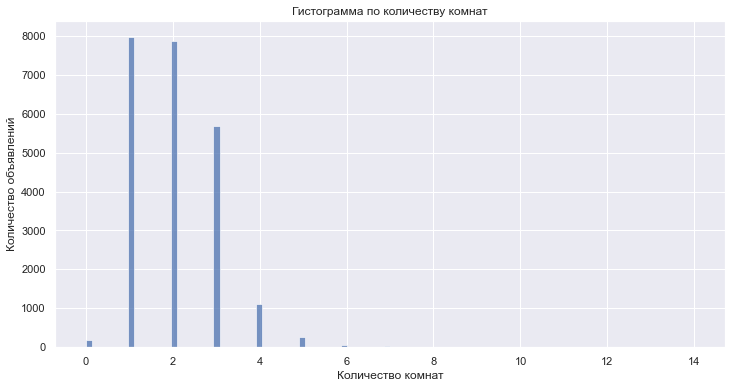

In [61]:
ax = sns.histplot(data=df['rooms'])
ax.set_title('Гистограмма по количеству комнат')
ax.set_xlabel('Количество комнат')
ax.set_ylabel('Количество объявлений')
plt.show();

Большая часть объектов имеет от 0 до 5 комнат.

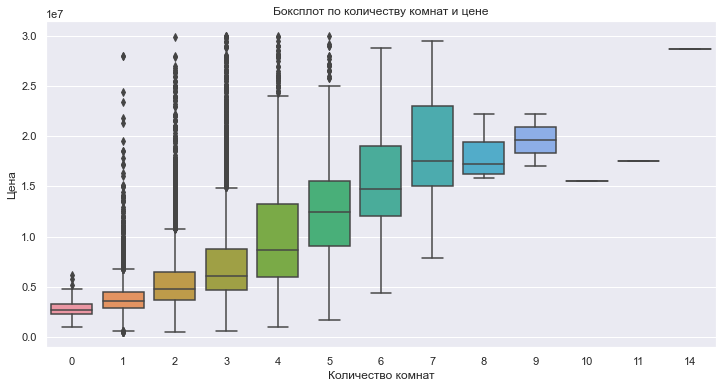

In [62]:
# Построим боксплот по комнатам

ax = sns.boxplot(x=df['rooms'], y=df['last_price'])
ax.set_title('Боксплот по количеству комнат и цене')
ax.set_xlabel('Количество комнат')
ax.set_ylabel('Цена')
plt.show();

По боксплоту видно увеличение медианной цены объекта с увеличением количества комнат (кроме 8-, 10- и 11-комнатных), при этом выбросы в 2-5-команатных рбъектах могут показывать цены большие, чем для 6-14 комнатных. Большое количество дорогих выбросов имеют и 1-комнатные квартиры, тогда как 0-комнатные показывают очень скромные результаты - даже выбросы этих объектов не превышают 1.5 межквартильных размаха однокомнатных.

In [63]:
# Медианное количество комнат

df['rooms'].median()

2.0

### Этажность дома

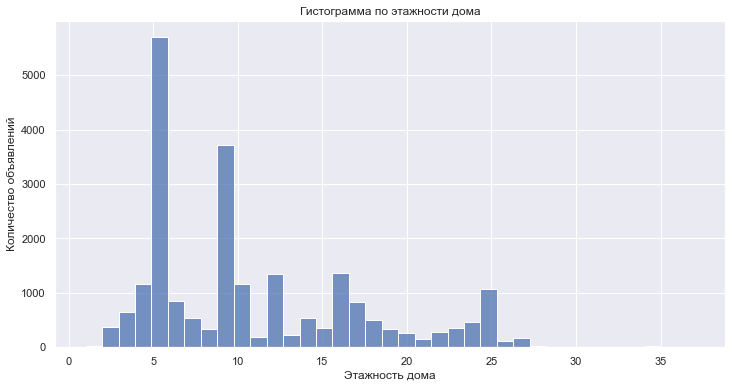

In [64]:
# Построим гистрограмму

ax = sns.histplot(data=df['floors_total'], bins=df['floors_total'].max())
ax.set_title('Гистограмма по этажности дома')
ax.set_xlabel('Этажность дома')
ax.set_ylabel('Количество объявлений')
plt.show();

Большая часть объектов находятся в домах с этажами менее 27, при этом лидируют 5- и 9-этажки

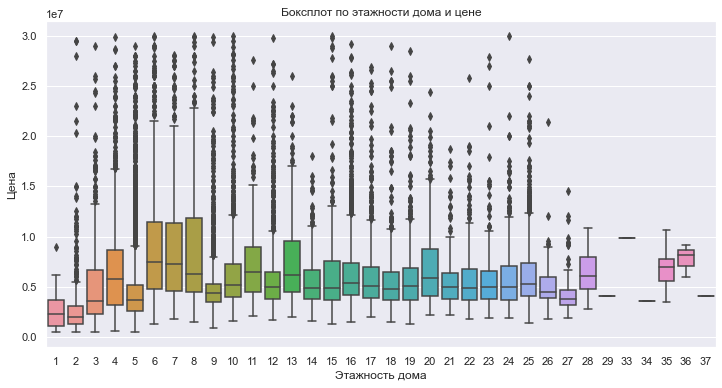

In [65]:
# Построим боксплот

ax = sns.boxplot(x=df['floors_total'], y=df['last_price'])
ax.set_title('Боксплот по этажности дома и цене')
ax.set_xlabel('Этажность дома')
ax.set_ylabel('Цена')
plt.show();

Выьросы в объектах с этажностью с 2 по 26 покрывают почти все ценовые категории датафреймы.

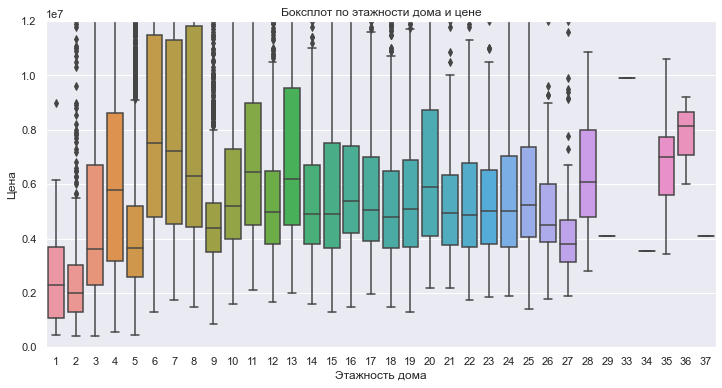

In [66]:
# Построим боксплот с ограничением по оси у

ax = sns.boxplot(x=df['floors_total'], y=df['last_price'])
ax.set_title('Боксплот по этажности дома и цене')
ax.set_xlabel('Этажность дома')
ax.set_ylabel('Цена')
plt.ylim(0, 12000000)
plt.show();

При этом медианная цена низкая в домах с этажностью 1-3, 5, 27. Наиболее высокая медианная цена в высотках с 35 и 36 этажами, а также с 6 и 7.

In [67]:
# Медианная этажность

df['floors_total'].median()

9.0

### Этаж объекта

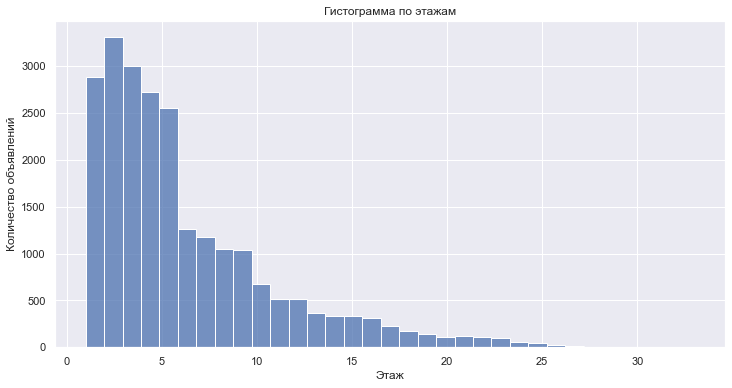

In [68]:
# Построим гистограмму

ax = sns.histplot(data=df['floor'], bins=df['floor'].max())
ax.set_title('Гистограмма по этажам')
ax.set_xlabel('Этаж')
ax.set_ylabel('Количество объявлений')
plt.show();

Большая часть объектов находится на этаже, меньшем чем 26

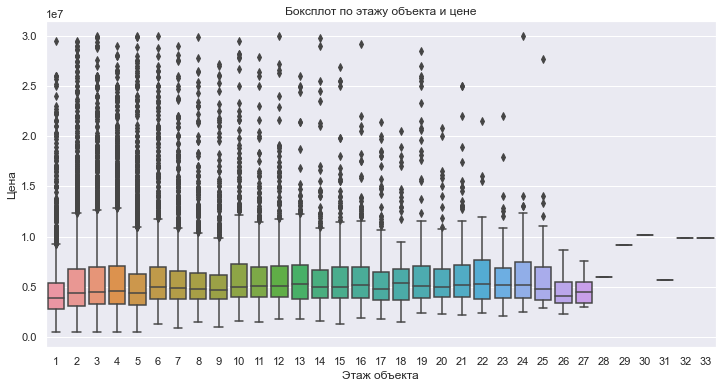

In [69]:
# Потроим боксплот

ax = sns.boxplot(x=df['floor'], y=df['last_price'])
ax.set_title('Боксплот по этажу объекта и цене')
ax.set_xlabel('Этаж объекта')
ax.set_ylabel('Цена')
plt.show();

Почти все этажи (кроме 26-33, имеющих минимум наблюдений) показывают выбросы, покраывающие все ценовые категории.

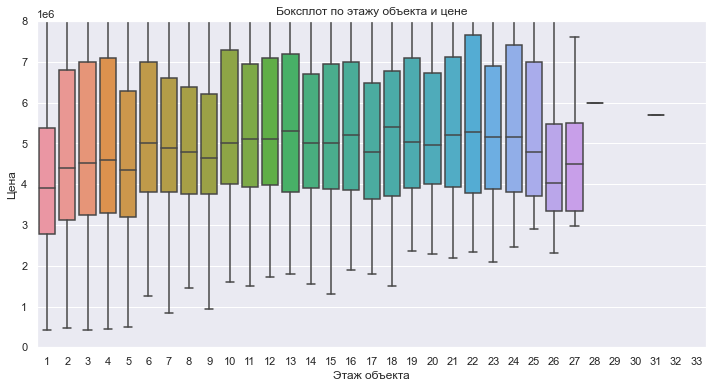

In [70]:
# Построим боксплот с ограничением по оси у

ax = sns.boxplot(x=df['floor'], y=df['last_price'])
ax.set_title('Боксплот по этажу объекта и цене')
ax.set_xlabel('Этаж объекта')
ax.set_ylabel('Цена')
plt.ylim(0, 8000000)
plt.show();

При этом для этажей 6-25 и 28 медианная цена примерно равна, чуть меньше цена для этажей 1-5 и 26

In [71]:
# Медианный этажн

df['floor'].median()

4.0

### Категория этажа

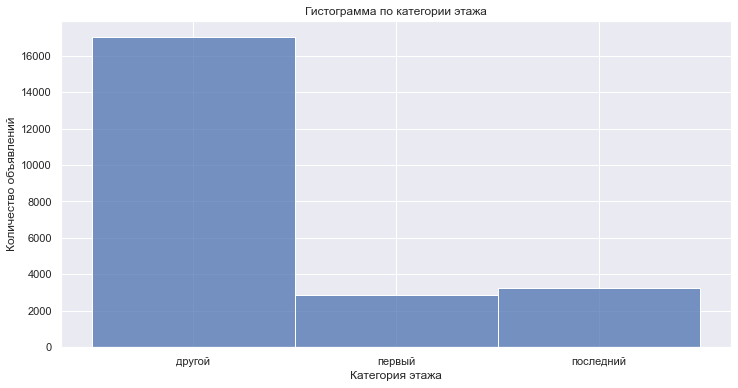

In [72]:
# Построим гистограмму

ax = sns.histplot(data=df['floor_category'])
ax.set_title('Гистограмма по категории этажа')
ax.set_xlabel('Категория этажа')
ax.set_ylabel('Количество объявлений')
plt.show();

Большая часть объектов не на первом и не на последнем этажах

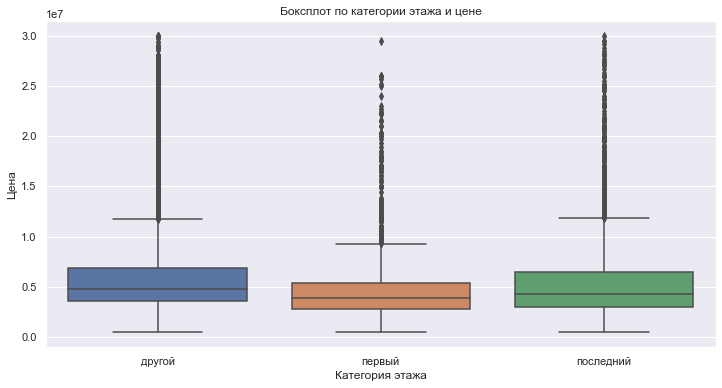

In [73]:
ax = sns.boxplot(x=df['floor_category'], y=df['last_price'])
ax.set_title('Боксплот по категории этажа и цене')
ax.set_xlabel('Категория этажа')
ax.set_ylabel('Цена')
plt.show();

Первый этаж показывает меньше дорогих выбросов, чем последний и другой, а первый - меньше чем другой.

### Высота потолков

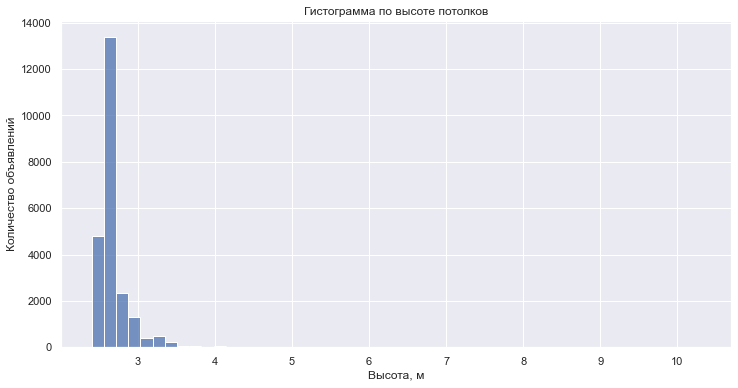

In [74]:
# Построим гистограмму

ax = sns.histplot(data=df['ceiling_height'], bins=50)
ax.set_title('Гистограмма по высоте потолков')
ax.set_xlabel('Высота, м')
ax.set_ylabel('Количество объявлений')
plt.show();

В большинстве объектов высота потолков не превышает 3.5 метра

In [75]:
# Медианная высота потолков

df['ceiling_height'].median()

2.65

### Расстояние до центра города в метрах

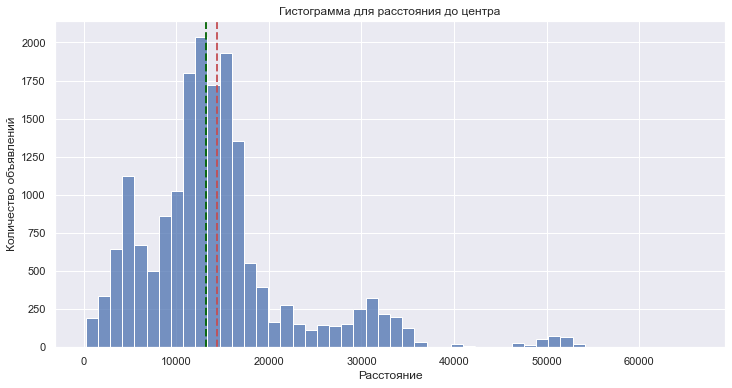

In [76]:
median_mean_histplot(df['cityCenters_nearest'], 'Гистограмма для расстояния до центра', 'Расстояние', 'Количество объявлений')

Большинство объектов, у которых указано расположение до центра, находятся от него на расстоянии менее 3.5 км.

In [77]:
# Медианное расстояние до центра

df['cityCenters_nearest'].median()

13174.0

### Расстояние до блажиайшего аэропорта в метрах

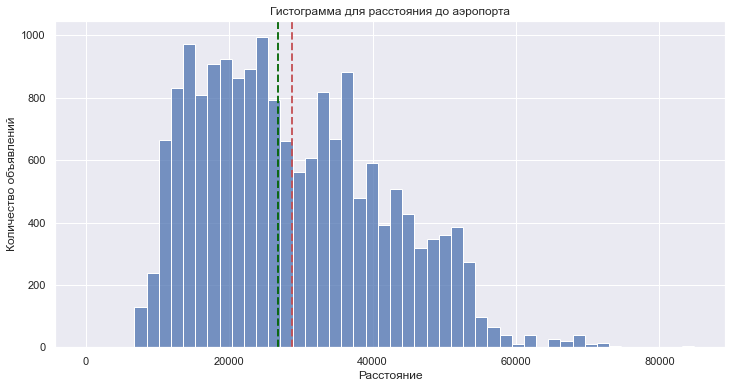

In [78]:
# Построим гистограмму

median_mean_histplot(df['airports_nearest'], 'Гистограмма для расстояния до аэропорта', 'Расстояние', 'Количество объявлений')

Большинство объектов, у которых указано расположение до аэропорта, находятся от него на расстоянии менее 6 км.

In [79]:
# Медианное расстояние до аэропорта

df['airports_nearest'].median()

26773.0

### Расстояние до ближайшего парка

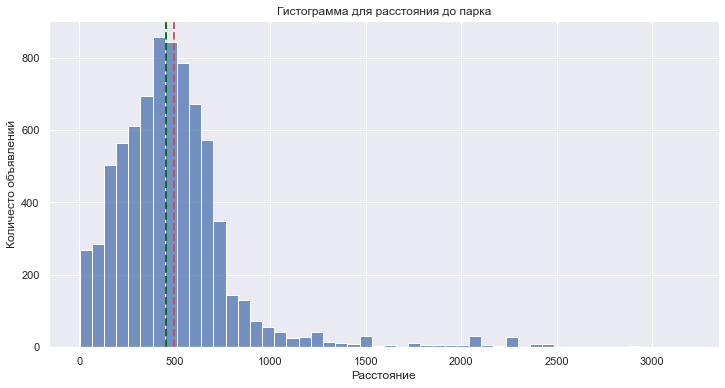

In [80]:
# Построим гистограмму

median_mean_histplot(df['parks_nearest'], 'Гистограмма для расстояния до парка', 'Расстояние', 'Количесто объявлений')

Большинство объектов, у которых указано расположение до парка, находятся от него на расстоянии менее 1.5 км.

In [81]:
# Медианное расстояние до ближайшего парка

df['parks_nearest'].median()

456.0

### День публикации и снятия объявления

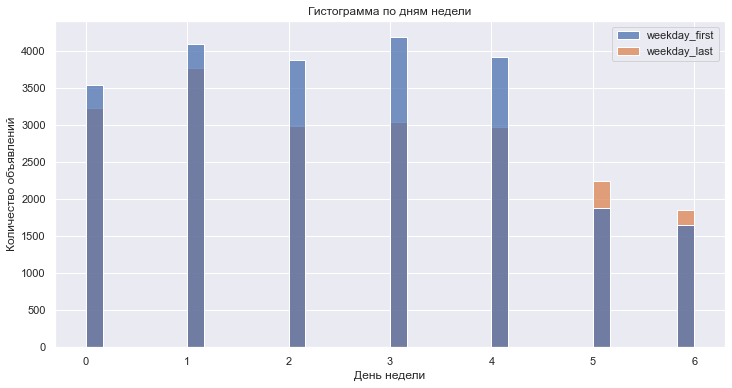

In [82]:
# Построим гистограмму

ax = sns.histplot(data=df[['weekday_first', 'weekday_last']])
ax.set_title('Гистограмма по дням недели')
ax.set_xlabel('День недели')
ax.set_ylabel('Количество объявлений')
plt.show();

Меньше всего квартир выставляется и снимается в выходные.

### Месяц публикации объявления

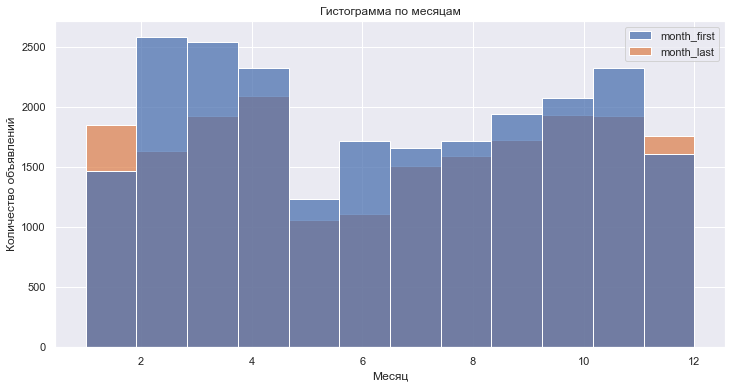

In [83]:
# Построим гистограмму

ax = sns.histplot(data=df[['month_first', 'month_last']], bins=12)
ax.set_title('Гистограмма по месяцам')
ax.set_xlabel('Месяц')
ax.set_ylabel('Количество объявлений')
plt.show();

Возможно, существует сезонный фактор:с мая по август публикуется и снимается меньше всего объектов

В качестве промежуточного итога можно по медианным данным описать типичный объект: 2-х комнатная квартира в 5-ти или 9-ти этажном доме (при этом не на первом и не на последнем этажах) с высотой потолков около 2.6 м. стоимостью около 4.5 миллионов, общей площадью около 50 м. кв. (при это жилая площадь - около 30 м. кв., площадь кухни - 9 м. кв.)

### Зависимости цены от различных факторов <a id='5'></a>

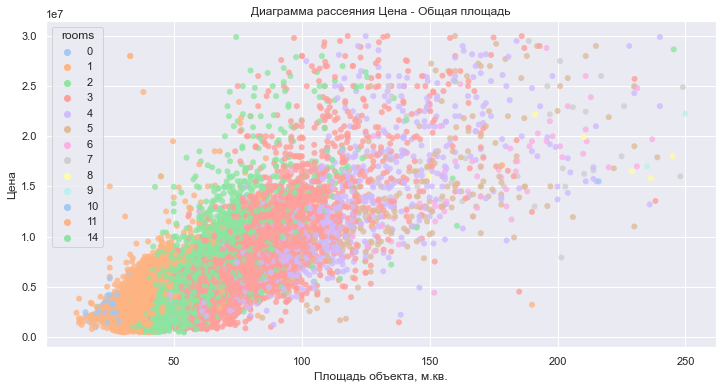

In [84]:
# Построим график Цена - общая площадь

colors = sns.color_palette('pastel', n_colors=df['rooms'].nunique())
ax = sns.scatterplot(data=df, x='total_area', y='last_price', hue='rooms', palette=colors, linewidth=0, alpha=0.8)
ax.set_title('Диаграмма рассеяния Цена - Общая площадь')
ax.set_xlabel('Площадь объекта, м.кв.')
ax.set_ylabel('Цена')
plt.show()

Виден тренд на повышение цены с повышением площади до 130 кв. м., квартиры в диапазоне от 130 кв. уже не показывают такой же тренд к повышению цены, но остаются равномерно распределены в ценовом диапазоне от 15 до 35 млн. Цветам четко выявляют кластеры по количеству комнат - чем больше площадь, тем больше комнат. Соответственно, с увеличением комнат увеличивается цена.

In [85]:
# Посчитаем коэффициент коррелиции Пирсона

df['last_price'].corr(df['total_area'])

0.7898469549016163

Значение коэффициента говорит о высокой положительной связи между ценой и общей площадью. Как правило, чем больше площадь - тем больше цена.  

In [86]:
# Посчитаем коэффициент коррелиции Пирсона для помещений с различной площадью

print('Коэффициент корреляции для помещений с площадью менее 100м')
print(df.query('total_area < 100')['last_price'].corr(df.query('total_area < 100')['total_area']))
print()
print('Коэффициент корреляции для помещений с площадью менее 130м')
print(df.query('total_area < 130')['last_price'].corr(df.query('total_area < 130')['total_area']))
print()
print('Коэффициент корреляции для помещений с площадью более 100м')
print(df.query('total_area > 100')['last_price'].corr(df.query('total_area > 100')['total_area']))
print()
print('Коэффициент корреляции для помещений с площадью более 130м')
print(df.query('total_area > 130')['last_price'].corr(df.query('total_area > 130')['total_area']))
print()
print('Коэффициент корреляции для помещений с площадью более 150м')
print(df.query('total_area > 150')['last_price'].corr(df.query('total_area > 150')['total_area']))

Коэффициент корреляции для помещений с площадью менее 100м
0.6725065425755565

Коэффициент корреляции для помещений с площадью менее 130м
0.7349901367924346

Коэффициент корреляции для помещений с площадью более 100м
0.4209431175216374

Коэффициент корреляции для помещений с площадью более 130м
0.23470907228198254

Коэффициент корреляции для помещений с площадью более 150м
0.10790020666774117


Чем больше площадь, тем меньше становится сила зависимости между ценой и общей площадью, если рассматривать их отдельно.

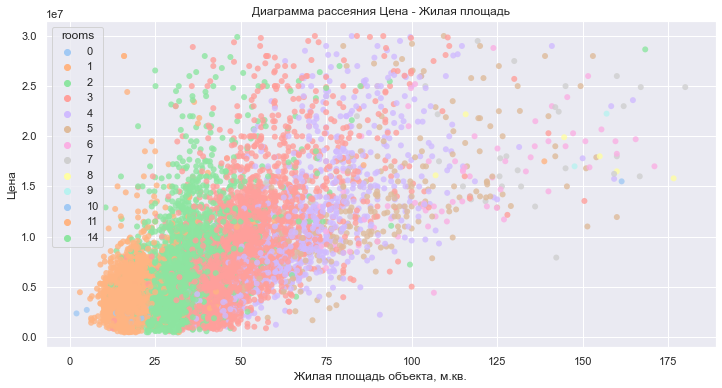

In [87]:
# Построим график Цена - жилая площадь

colors = sns.color_palette('pastel', n_colors=df['rooms'].nunique())
ax = sns.scatterplot(data=df, x='living_area', y='last_price', hue='rooms', palette=colors, linewidth=0, alpha=0.8)
ax.set_title('Диаграмма рассеяния Цена - Жилая площадь')
ax.set_xlabel('Жилая площадь объекта, м.кв.')
ax.set_ylabel('Цена')
plt.show()

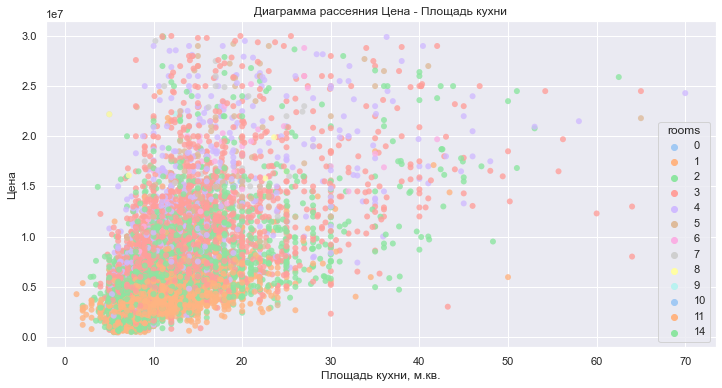

In [88]:
# Построим график Цена - площадь кухни

colors = sns.color_palette('pastel', n_colors=df['rooms'].nunique())
ax = sns.scatterplot(data=df, x='kitchen_area', y='last_price', hue='rooms', palette=colors, linewidth=0, alpha=0.8)
ax.set_title('Диаграмма рассеяния Цена - Площадь кухни')
ax.set_xlabel('Площадь кухни, м.кв.')
ax.set_ylabel('Цена')
plt.show()

В целом, зависимости цена от площадей кухни и жилой показывают примерно то же распределение, что и зависимость цены от общей площади. Лишь отсутствует четкая зависимость между количеством комнат и площадью кухни.

In [89]:
# Создадим сводную таблицу Цена - количество комнат

pivot_room = df.pivot_table(index='rooms', values='last_price', aggfunc='median').reset_index()

pivot_room

,rooms,last_price
0,0,2690000.000000
1,1,3600000.000000
2,2,4750000.000000
3,3,6100000.000000
4,4,8625000.000000
5,5,12400000.000000
6,6,14700000.000000
7,7,17500000.000000
8,8,17250000.000000
9,9,19625000.000000


Text(0, 0.5, 'Медианная цена')

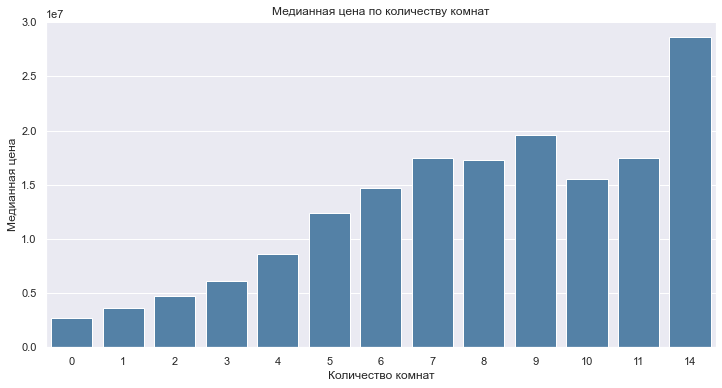

In [90]:
# Построим график Цена - количество комнат

ax = sns.barplot(data=pivot_room, x='rooms', y='last_price', color='steelblue')
ax.set_title('Медианная цена по количеству комнат')
ax.set_xlabel('Количество комнат')
ax.set_ylabel('Медианная цена')


Видна прямая зависимость между количеством комнат и ценой (с просадкой по цене с 10 комнатами).

In [91]:
# Расчитает коэффициент Пирсона

df['last_price'].corr(df['rooms'])

0.5121568998121296

Значение коэффициента говорит о наличии средней положительной связи. 

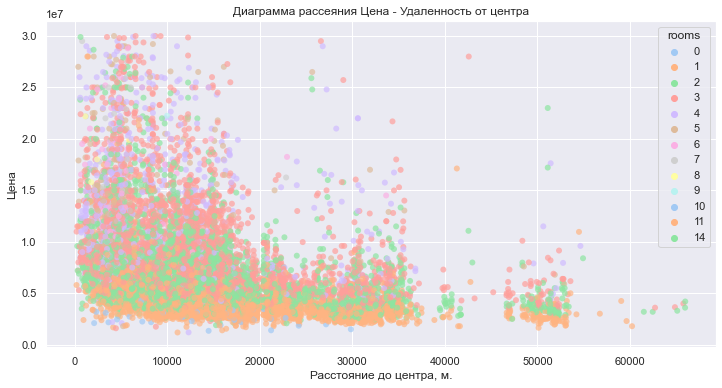

In [92]:
# Построим график Цена - удаленность от центра 

colors = sns.color_palette('pastel', n_colors=df['rooms'].nunique())
ax = sns.scatterplot(data=df, x='cityCenters_nearest', y='last_price', hue='rooms', palette=colors, linewidth=0, alpha=0.7)
ax.set_title('Диаграмма рассеяния Цена - Удаленность от центра')
ax.set_xlabel('Расстояние до центра, м.')
ax.set_ylabel('Цена')
plt.show()

Действительно, существует тренд на снижение минимальной стоимости жилья до 10000м от центра, далее тренд на удешевление сохраняется, но приобретает более плавный характер. Доля дорого многокомнатного жилья снижается после 10км, после еще резко снижается около 18км от центра.. Отсюда, самое большое количество дорогих квартир находится в диапазоне 0 - 180км. 

In [93]:
# Посчитаем коэффициент Пирсона

df['last_price'].corr(df['cityCenters_nearest_km'])

-0.3455789355955117

Коэффициент говорит о наличии слабой отрицательной связи.

In [94]:
# Посчитаем коэффициент Пирсона для объектом менее чем в 20000м

df.query('cityCenters_nearest < 20000')['last_price'].corr(df.query('cityCenters_nearest < 20000')['cityCenters_nearest'])

-0.43156946976013705

Для объектов менее чем в 20000м отрицательная связь сильнее.

In [95]:
# Построим общую таблицу корреляций для наших параметров

(
df[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'cityCenters_nearest']] 
.corr().style.background_gradient('coolwarm')
)

,last_price,total_area,living_area,kitchen_area,rooms,cityCenters_nearest
last_price,1.000000,0.789847,0.690247,0.607015,0.512157,-0.344716
total_area,0.789847,1.000000,0.936027,0.561392,0.797839,-0.220476
living_area,0.690247,0.936027,1.000000,0.336360,0.872252,-0.210528
kitchen_area,0.607015,0.561392,0.336360,1.000000,0.198047,-0.170516
rooms,0.512157,0.797839,0.872252,0.198047,1.000000,-0.161844
cityCenters_nearest,-0.344716,-0.220476,-0.210528,-0.170516,-0.161844,1.000000


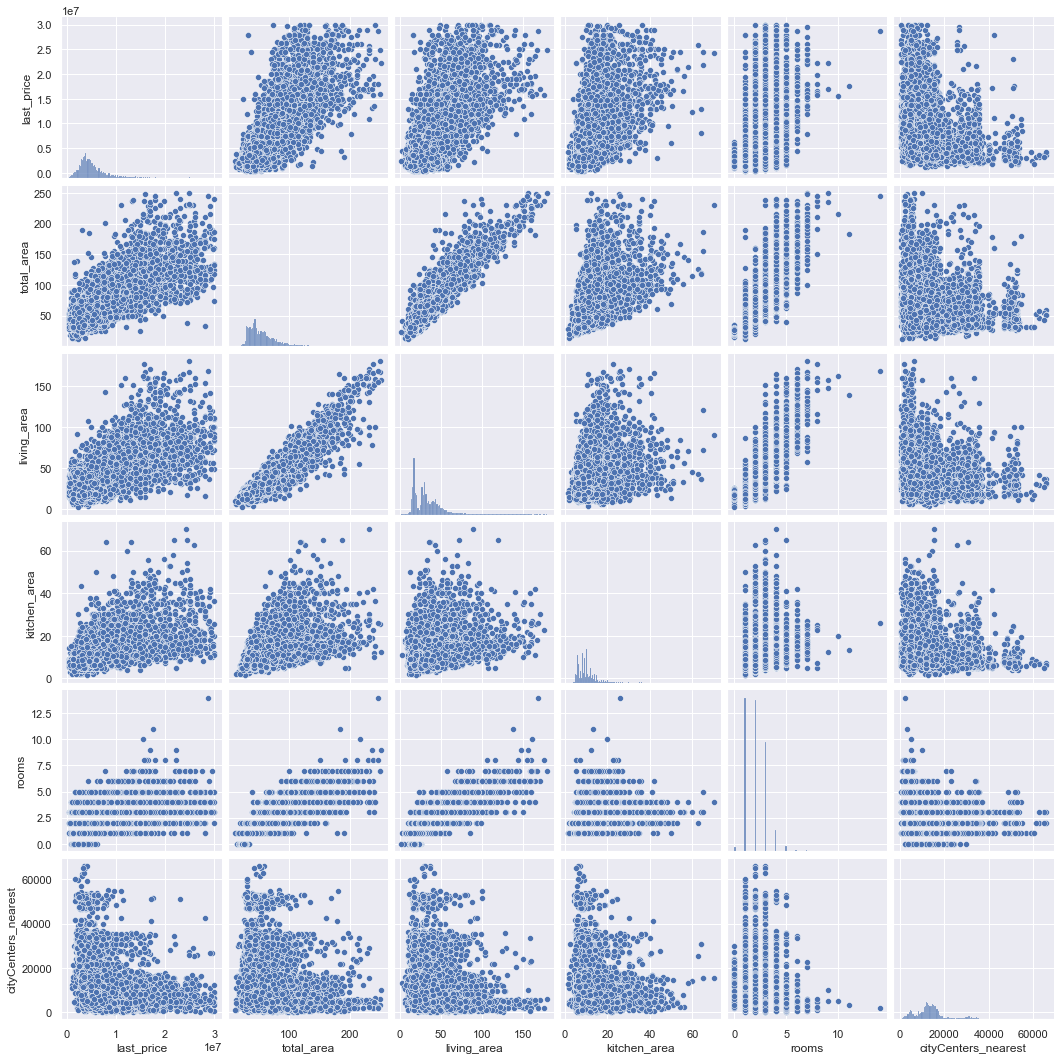

In [96]:
# И графически

sns.pairplot(df[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'cityCenters_nearest']]);

In [97]:
# Сравним с аналогичными показателями корреляции в Санкт-Петербурге

(
df.query('locality_name == "Санкт-Петербург"')
    [['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'cityCenters_nearest']]
    .corr().style.background_gradient('coolwarm')
)

,last_price,total_area,living_area,kitchen_area,rooms,cityCenters_nearest
last_price,1.000000,0.822761,0.722375,0.627130,0.547819,-0.411802
total_area,0.822761,1.000000,0.938850,0.571358,0.800894,-0.334343
living_area,0.722375,0.938850,1.000000,0.353193,0.871746,-0.336114
kitchen_area,0.627130,0.571358,0.353193,1.000000,0.219600,-0.195682
rooms,0.547819,0.800894,0.871746,0.219600,1.000000,-0.266941
cityCenters_nearest,-0.411802,-0.334343,-0.336114,-0.195682,-0.266941,1.000000


Одни и те же факторы одинаково влияют на цены и в Санкт-Петербурге, и в общем датафрейме

In [98]:
# Построим сводную таблицу Цена - категория этажа

pivot_floor_category = (
                        df.pivot_table(index='floor_category', values='last_price', aggfunc='median')
                        .reset_index().sort_values('last_price')
                        )

pivot_floor_category

,floor_category,last_price
1,первый,3900000.000000
2,последний,4250000.000000
0,другой,4800000.000000


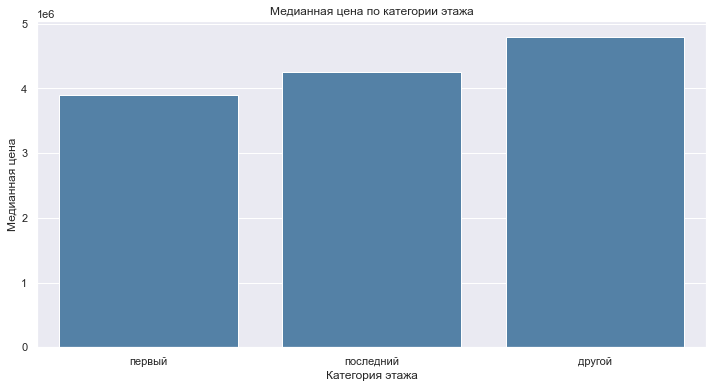

In [99]:
# Построим график зависимости Цена - этаж

ax = sns.barplot(data=pivot_floor_category, x='floor_category', y='last_price', color='steelblue')
ax.set_title('Медианная цена по категории этажа')
ax.set_xlabel('Категория этажа')
ax.set_ylabel('Медианная цена')
plt.show()

Цены четко разделяются на три ценовые категории: самые низкие цены - за квартиры на первом этаже, далее идут на последнем, и самые дорогие - на других этажах.

In [100]:
# Построим сводную таблицу Цена - день размещения объявления

pivot_weekday = (
    df.pivot_table(index='weekday_first', values='last_price', aggfunc='median').reset_index()
    .rename(columns={'weekday_first':'weekday'})
)

pivot_weekday

,weekday,last_price
0,0,4600000.000000
1,1,4700000.000000
2,2,4650000.000000
3,3,4600000.000000
4,4,4500000.000000
5,5,4500000.000000
6,6,4500000.000000


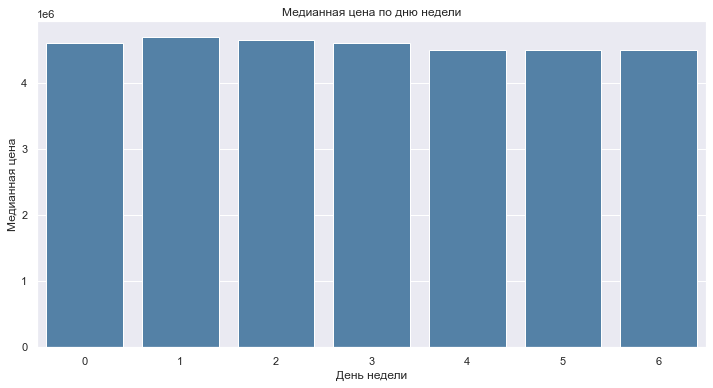

In [101]:
# Построим график Цена - день размещения объявления

ax = sns.barplot(data=pivot_weekday, x='weekday', y='last_price', color='steelblue')
ax.set_title('Медианная цена по дню недели')
ax.set_xlabel('День недели')
ax.set_ylabel('Медианная цена')
plt.show()

In [102]:
# Посмотрим на размах цен

pivot_weekday['last_price'].max() - pivot_weekday['last_price'].min()

200000.0

По-видимому, никакой реальной связи между ценой и днем недел нет: разница между минимальным и максимальным значениям - 200к.

In [103]:
# Построим сводную таблицу Цена - месяц размещения объявления

pivot_month = (
    df.pivot_table(index='month_first', values='last_price', aggfunc='median').reset_index()
    .rename(columns={'month_first':'month'})
)

pivot_month

,month,last_price
0,1,4599500.000000
1,2,4600000.000000
2,3,4600000.000000
3,4,4750000.000000
4,5,4500000.000000
5,6,4380000.000000
6,7,4600000.000000
7,8,4522500.000000
8,9,4650000.000000
9,10,4550000.000000


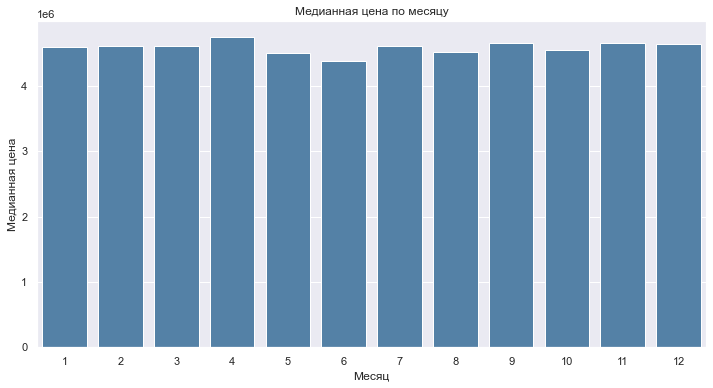

In [104]:
# Построим график Цена - месяц размещения объявления

ax = sns.barplot(data=pivot_month, x='month', y='last_price', color='steelblue')
ax.set_title('Медианная цена по месяцу')
ax.set_xlabel('Месяц')
ax.set_ylabel('Медианная цена')
plt.show()

In [105]:
# Посмотрим на размах цен

pivot_month['last_price'].max() - pivot_month['last_price'].min()

370000.0

Разница между максимальным и минимальным значениям по месяцам также не очень высокая.

In [106]:
df.pivot_table(index='year_last', values='last_price', aggfunc='median')

,last_price
year_last,
2016.000000,4500000.000000
2017.000000,4400000.000000
2018.000000,4400000.000000
2019.000000,4950000.000000


In [107]:
# Построим сводную таблицу Цена - год размещения объявления

pivot_year = (
    df.pivot_table(index='year_first', values='last_price', aggfunc='median').reset_index()
    .rename(columns={'year_first':'year'})   
)

pivot_year

,year,last_price
0,2014,7500000.000000
1,2015,5200000.000000
2,2016,4500000.000000
3,2017,4490000.000000
4,2018,4527500.000000
5,2019,5000000.000000


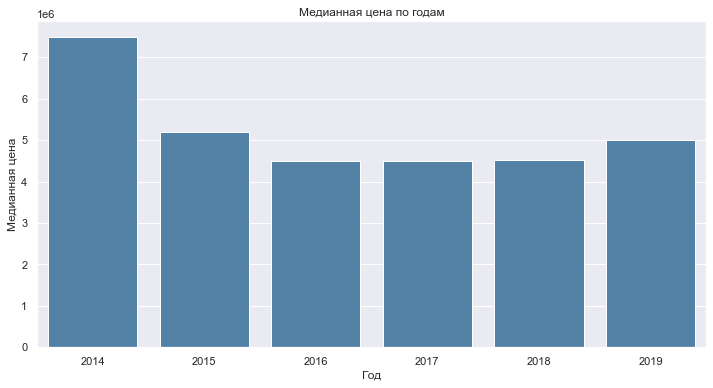

In [108]:
# Построим график Цена - год размещения/снятия объявления

ax = sns.barplot(data=pivot_year, x='year', y='last_price', color='orange')
ax = sns.barplot(data=pivot_year, x='year', y='last_price', color='steelblue')
ax.set_title('Медианная цена по годам')
ax.set_xlabel('Год')
ax.set_ylabel('Медианная цена')
plt.show()

Произошло резкое падение медианной стоимости между 2014 и 2015 годом. Видимо, это связаны с небольшим количеством данных за 2014-й. Для более объективной картины посмотрим динамику по стимости квадратного метра без учета 2014-го года.

In [109]:
# Построим сводную таблицу Цена квадратного метра - год размещения/снятия объявления

pivot_year_meter = (
    df.query('year_first > 2014').pivot_table(index='year_first', values='meter_price', aggfunc='median').reset_index()
    .rename(columns={'year_first':'year'})
)

pivot_year_meter

,year,meter_price
0,2015,92308.000000
1,2016,91250.000000
2,2017,92079.000000
3,2018,95435.000000
4,2019,102835.000000


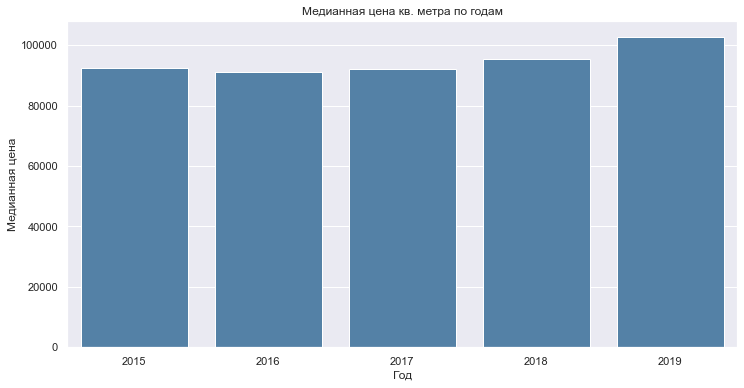

In [110]:
# Построим график Цена квадратного метра - год размещения/снятия объявления

ax = sns.barplot(data=pivot_year_meter, x='year', y='meter_price', color='steelblue')
ax.set_title('Медианная цена кв. метра по годам')
ax.set_xlabel('Год')
ax.set_ylabel('Медианная цена')
plt.show()

In [111]:
# Для оценки тренда цен посмотри на скользещее среднее по годам

price_rolling = (
    df.query('year_first > 2014').sort_values('last_day_exposition')['meter_price'].rolling(window=2000).mean().dropna()
    .reset_index().drop('index', axis=1).join(df.sort_values('last_day_exposition')['last_day_exposition'].reset_index())
)

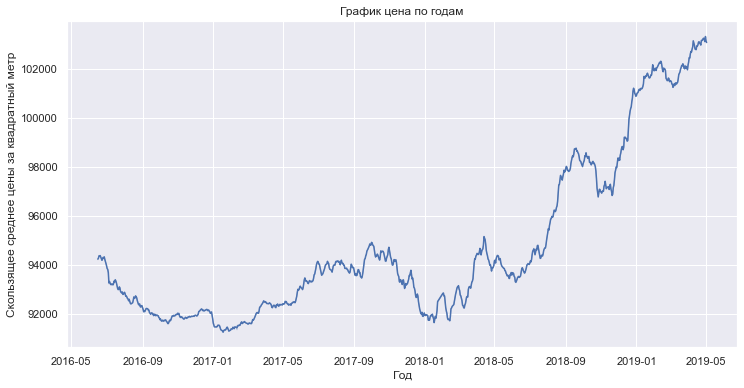

In [112]:
ax = sns.lineplot(data=price_rolling, x='last_day_exposition', y='meter_price')
ax.set_title('График цена по годам')
ax.set_xlabel('Год')
ax.set_ylabel('Скользящее среднее цены за квадратный метр')
plt.show();

С 2018 года идет уверенный рост цен за квадратный метр.

### Выделение 10 локаций с наибольшим количеством объявлений <a id='6'></a>

In [113]:
# Выделим 10 населенных пунктов с интересующими параметрами

df_cities = (
    df.groupby('locality_name')
    .agg({'last_price':'count', 'meter_price':'median'}).sort_values('last_price', ascending=False).head(10).reset_index()
    .rename(columns={'last_price':'objects_count'})
    .merge(df.groupby('locality_name').agg({'last_price':'median'}).reset_index()
    .rename(columns={'last_price':'median_price'}), on='locality_name', how='left')
    .merge(df.groupby('locality_name').agg({'days_exposition':'median'}).reset_index()
    .rename(columns={'days_exposition':'median_days_exposition'}), on='locality_name', how='left')
                            )
df_cities['meter_price'] = df_cities['meter_price'].round()

df_cities

,locality_name,objects_count,meter_price,median_price,median_days_exposition
0,Санкт-Петербург,15242,104164.000000,5490000.000000,94.000000
1,Мурино,583,86119.000000,3400000.000000,77.000000
2,Кудрово,469,95588.000000,3890000.000000,72.500000
3,поселок Шушары,437,76829.000000,3950000.000000,92.000000
4,Всеволожск,395,65789.000000,3450000.000000,124.500000
5,Пушкин,367,100000.000000,5150000.000000,137.000000
6,Колпино,336,74724.000000,3600000.000000,74.000000
7,поселок Парголово,326,91580.000000,4115000.000000,77.000000
8,Гатчина,303,67647.000000,3090000.000000,100.500000
9,Выборг,237,58158.000000,2897000.000000,99.500000


Санкт-Петебрург - лидер по количеству объявлений. В столице области их почти что в 30 раз больше, чем в Мурино, находящимся на 2-м месте. 

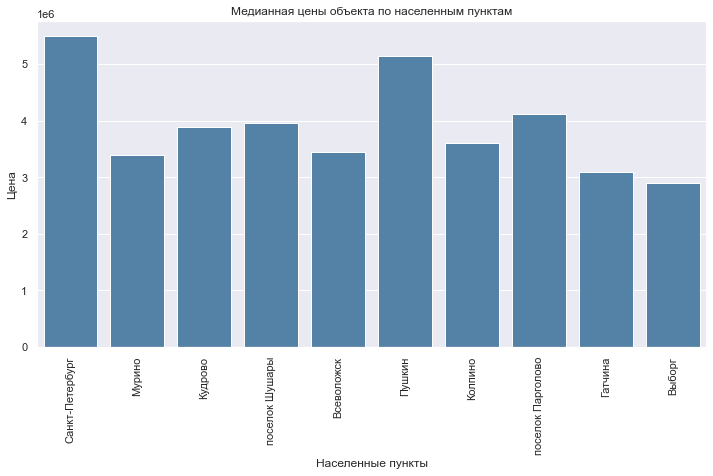

In [114]:
# Построим барплот по населенным пунктам и медианной цене

ax = sns.barplot(data=df_cities, x='locality_name', y='median_price', color='steelblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Медианная цены объекта по населенным пунктам')
ax.set_xlabel('Населенные пункты')
ax.set_ylabel('Цена')
plt.show()

Судя по медианным данным, самые дорогие объекты находятся в Санкт-Петербурге и Пушкине

In [115]:
# Создадим список населенных пунктов с наибольшим количеством объявлений

city_list = list(df_cities['locality_name'])

city_list

['Санкт-Петербург',
 'Мурино',
 'Кудрово',
 'поселок Шушары',
 'Всеволожск',
 'Пушкин',
 'Колпино',
 'поселок Парголово',
 'Гатчина',
 'Выборг']

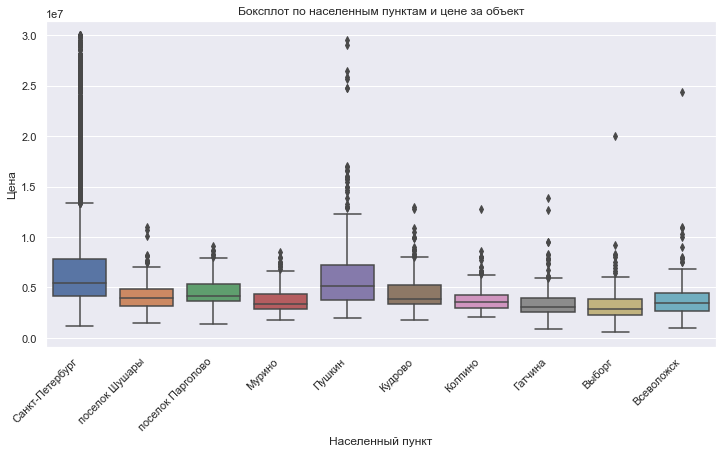

In [116]:
# Создадим боксплот по населенным пунктам и цене объекта

ax = sns.boxplot(data=df.query('locality_name in @city_list'), x='locality_name', y='last_price')
ax.set_title('Боксплот по населенным пунктам и цене за объект')
ax.set_xlabel('Населенный пункт')
ax.set_ylabel('Цена')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show();

Больше всего дорогих выбросов также показывают Санкт-Петербург и Пушкин.

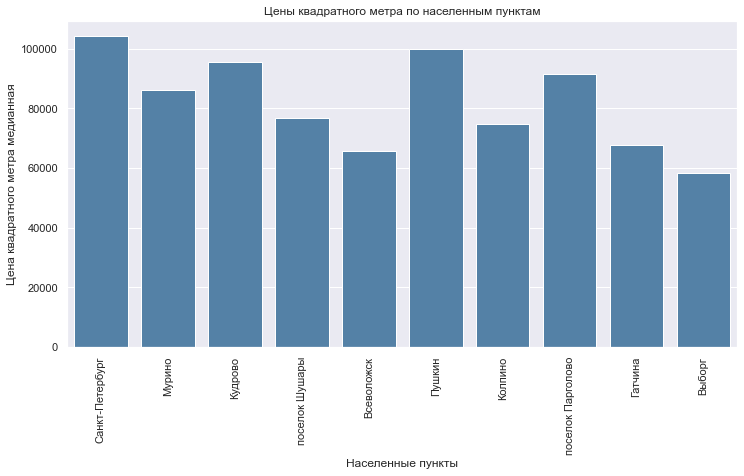

In [117]:
# Построим барплот по населенным пунктам и медианной цене квадратного метра

ax = sns.barplot(data=df_cities, x='locality_name', y='meter_price', color='steelblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Цены квадратного метра по населенным пунктам')
ax.set_xlabel('Населенные пункты')
ax.set_ylabel('Цена квадратного метра медианная')
plt.show()

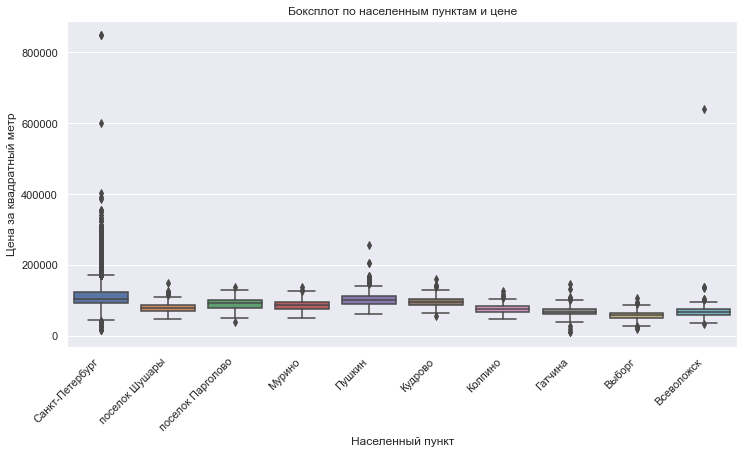

In [118]:
# Создадим боксплот по населенным пунктам и цене за квадратный метр

ax = sns.boxplot(data=df.query('locality_name in @city_list'), x='locality_name', y='meter_price')
ax.set_title('Боксплот по населенным пунктам и цене')
ax.set_xlabel('Населенный пункт')
ax.set_ylabel('Цена за квадратный метр')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show();

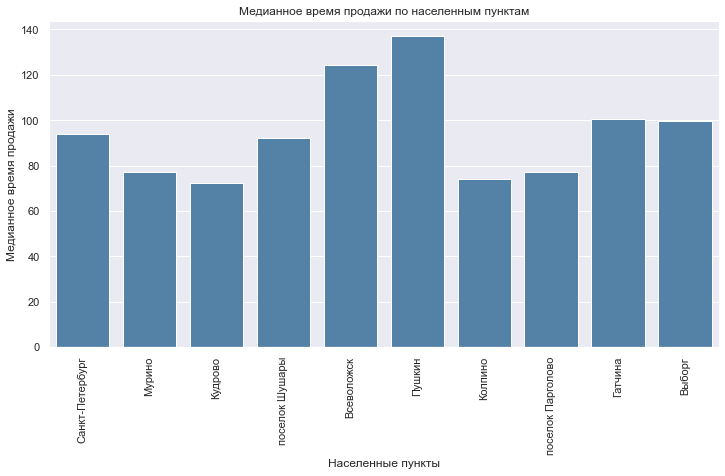

In [119]:
# Построим барплот по населенным пунктам и медианному времени продажи

ax = sns.barplot(data=df_cities, x='locality_name', y='median_days_exposition', color='steelblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Медианное время продажи по населенным пунктам')
ax.set_xlabel('Населенные пункты')
ax.set_ylabel('Медианное время продажи')
plt.show()

Судя по медианному времени продажи, дольше всего продаются объекты в Пушкине и Всеволжске

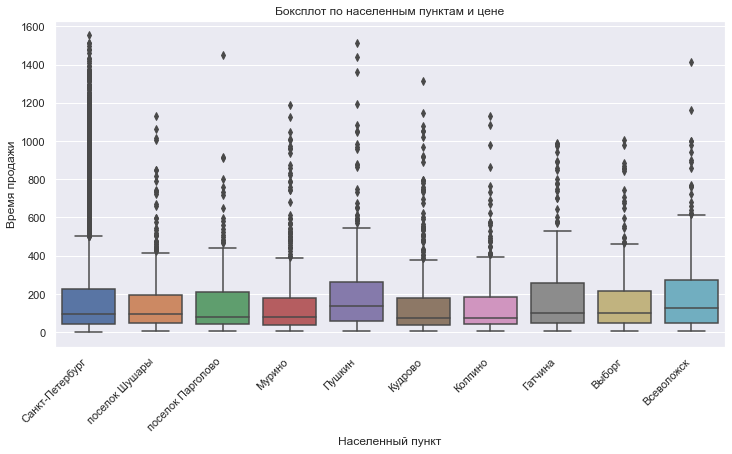

In [120]:
# Создадим боксплот по населенным пунктам и времени продажи

ax = sns.boxplot(data=df.query('locality_name in @city_list'), x='locality_name', y='days_exposition')
ax.set_title('Боксплот по населенным пунктам и цене')
ax.set_xlabel('Населенный пункт')
ax.set_ylabel('Время продажи')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show();

### Выделение центра Санкт-Петербурга  <a id='7'></a>

In [121]:
# Посмотрим распределение цен по удаленности от Центра в Санкт-Петербурге

spb_price = ( 
            df.query('locality_name == "Санкт-Петербург"').groupby('cityCenters_nearest_km').agg({'last_price':'median'})
            .reset_index()
            )

spb_price['cityCenters_nearest_km'] = spb_price['cityCenters_nearest_km'].astype('int')

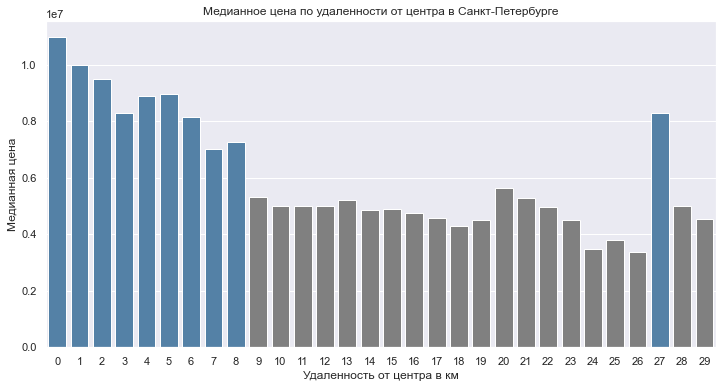

In [122]:
cols = ['grey' if (x < 6000000) else 'steelblue' for x in spb_price['last_price']]
ax = sns.barplot(data=spb_price, x='cityCenters_nearest_km', y='last_price',  palette=cols)
ax.set_title('Медианное цена по удаленности от центра в Санкт-Петербурге')
ax.set_xlabel('Удаленность от центра в км')
ax.set_ylabel('Медианная цена')
plt.show();

Судя по резкому уменьшению медианной цены на 9км, выделим центр на 8км

In [123]:
# Объекты на 27 километре

df.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km == 27')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,floor_category,living_total_area_ratio,weekday_first,month_first,year_first,last_day_exposition,weekday_last,month_last,year_last,cityCenters_nearest_km
748,13,14350000.000000,74.000000,2017-11-28,2,3.130000,5,30.000000,3,NaN,...,другой,0.405405,1,11,2017,2018-04-05,3.000000,4.000000,2018.000000,27.000000
5961,6,2250000.000000,32.000000,2018-02-27,1,2.650000,2,16.500000,2,NaN,...,последний,0.515625,1,2,2018,2018-08-24,4.000000,8.000000,2018.000000,27.000000


Всплеск по ценам на 27 километре связан с одним дорогим объектом.

In [124]:
# Посмотрим на медианную стоимость по центру

df.query('cityCenters_nearest_km < 9')['last_price'].median()

8500000.0

## Выводы <a id='8'></a>

В качестве рабочего материала были использованы данные сервиса Яндекс Недвижимость (архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет - 22 столбца на 23699 строки в сырой таблице, в итоговой - 20099 строк, общая потеря данных 15%). В данных были выявлены погрешности (как пропуски, выбросы, некорректные типы данных), которые, если была возможность, корректировались в процессе предобработки. Также были добавлены дополнительные столбцы: цена квадратного метра, категория этажа квартиры, соотношение жилой и общей площади, соотношение кухни и общей площади, а также день, месяц и год публикации и снятия объявления. После предобработки был проведен анализ данных, во время которого было выявлено, что:
 
  - По медианным показателям типичный объект имеет следующие характеристики:  2-х комнатная квартира в 5-ти или 9-ти этажном доме (при этом не на первом и не на последнем этажах) с высотой потолков около 2.6 м. стоимостью около 4.5 миллионов, общей площадью около 50 м. кв. (при это жилая площадь - около 30 м. кв., площадь кухни - 9 м. кв.)
  
 
  - Площадь влияет на стоимость жилья. Как правило, чем выше площадь, тем выше цена.
  
  
  - Число комнат влияет на стоимость. Как правило, чем больше комнат, тем выше цена.
  
  
  - Удаленность от центра влияет на стоимость. Как правило, чем ближе к центру, тем выше минимальная цена недвижимости и больше недвижимости с большим ценником.
  
  
  - Этаж квартиры влияет на стоимость. Самым дешевым является первый этаж, далее идет последний, и самые дорогие квартиры на других этажах.
  
  
  - День недели и месяц  размещения объявления практически не влияют на стоимость. 
  
  
  - С 2018 года идет уверенный рост цен за квадратный метр.  
  
  
  - Факторы, влияющие на стоимость квартиры в общей таблице не отличаются от факторов по Санкт-Петербургу
  
  
  - Населенный пункт влияет на стоимость. Как по медианной цене, так и по количеству больших выбросов по цене за объект лидируют Санкт-Петербург и Пушкин. По цене квадратного метра также лидируют данные города, однако у Санкт-Петербурга несравнимо больше дорогих выбросов
  
  
  - Нахождение объекта в центре Санкт-Петербурга является важным фактором, влияющим на стоимость
      
  
  - Медианная стоимость объекта по общей базе составляет 4.6 миллионов, по центру - 8.5 миллионов